#### Notebook for analysis of long-term carbon and climate dynamics in CMIP6 ESMs and CMIP6-era EMICs.  

Scenarios include the SSP5-8.5 and SSP5-3.4-overshoot in order to bracket the range of high and low emissions and their long-term implications.



In [1]:
def monthly_to_annual(array):
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [2]:
import numpy as np
import sys
import xarray as xr
from scipy.io import netcdf
import matplotlib.pyplot as plt
import cftime

plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [10, 6]

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import pandas as pd

In [3]:
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.titlesize':12}) 
plt.rcParams.update({'axes.labelsize':17}) 
plt.rcParams.update({'xtick.labelsize':15}) 
plt.rcParams.update({'ytick.labelsize':15}) 
plt.rcParams.update({'legend.fontsize':12}) 

In [4]:
exps_list = ('historical','ssp585','ssp534-over')
vars_list = ('tas','fgco2','nbp','cVeg','cSoil')
gridvars_list = ('areacella','areacello','sftlf','sftof')

models_list = ('CanESM5','CESM2-WACCM', 'IPSL-CM6A-LR', 'UKESM1', 'UVic-ESCM')

globally_gridded = [True, True, True, True, False]#, False]

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)
n_future_scens = nexps-1
ngridvars = len(gridvars_list)


file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

file_master_list_grids = [[[] for j in range(ngridvars)] for k in range(nmodels)]
### index this file as [model_i][gridvar_i]

startyear_list = [[[] for i in range(nexps )] for k in range(nmodels)]

startyear_exps = [1850, 2015, 2040]
endyear_exps = [2014, 2299, 2299]
nyears_total = 2299-1850+1
years = np.arange(nyears_total)+startyear_exps[0]

years_to_average_gmst = 50

ssp534os_color = [154./256., 109./256., 201./256.]
ssp585_color = [132./256., 11./256., 34./256.]

dashlist = ['solid',(0, (10, 2)),'dotted','dashdot','--']#, (1, (7, 2,1,2,1,2))]


labels_list = tuple(['SSP5-8.5', 'SSP5-3.4-overshoot', ''] + list(models_list))

oceanmodel_latvar_names = [[] for k in range(nmodels)]

lat_bin_edges_for_fgco2_zonalmean_plots = np.arange(-90., 92.5, 2.5)
lat_bin_centers_for_fgco2_zonalmean_plots = np.arange(-88.75, 88.75+2.5, 2.5)

#### lo-res ocean zonal-mean plots for debugging
#lat_bin_edges_for_fgco2_zonalmean_plots = np.arange(-90., 100., 10.)
#lat_bin_centers_for_fgco2_zonalmean_plots = np.arange(-85, 95., 10.)

### super lo-res ocean zonal-mean plots for debugging
#lat_bin_edges_for_fgco2_zonalmean_plots = np.arange(-90., 110., 20.)
#lat_bin_centers_for_fgco2_zonalmean_plots = np.arange(-80, 100., 20.)

n_lat_bins_fgco2_zonalmean = len(lat_bin_centers_for_fgco2_zonalmean_plots)

make_zonal_mean_fgco2_plots = True  ### this requires a regridding step so is slow (~30 mins). set to False if not needed.


In [5]:
### gather all the files for CanESM5

model_i = models_list.index('CanESM5')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Oyr_CanESM5_historical_r1i1p1f1_gn_1850-2014.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_Emon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_Emon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cSoil_Emon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'cSoil_Emon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_Emon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cSoil_Emon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cVeg_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'cVeg_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cVeg_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]


file_master_list_grids[model_i] = [
'areacella_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

oceanmodel_latvar_names[model_i] = 'latitude'

In [6]:
### gather all the files for CESM2-WACCM

model_i = models_list.index('CESM2-WACCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Omon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-208912.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_209001-210012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_Emon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'cSoil_Emon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'cSoil_Emon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_Lmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'cVeg_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

    
file_master_list_grids[model_i] = [
'areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

oceanmodel_latvar_names[model_i] = 'lat'

### due to the CESM2 spinup bug, we may need to filter out those points affected by it.  
### get the PI control GPP field, and create a mask based on those points that had zero GPP.

cesm2_gpp = xr.open_dataset('gpp_Lmon_CESM2-WACCM_piControl_r1i1p1f1_gn_045001-049912.nc')
cesm2_zerogppmask = cesm2_gpp['gpp'].mean(dim='time') > 0.
#cesm2_zerogppmask.plot()

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'gpp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [7]:
### gather all the files for IPSL-CM6A-LR

model_i = models_list.index('IPSL-CM6A-LR')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Oyr_IPSL-CM6A-LR_historical_r1i1p1f1_gn_1850-2014.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_Emon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_Emon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'cSoil_Emon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_Emon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'cSoil_Emon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'cVeg_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'cVeg_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]


file_master_list_grids[model_i] = [
'areacella_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
'areacello_Ofx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
None
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

oceanmodel_latvar_names[model_i] = 'nav_lat'

In [8]:
### gather all the files for UKESM1

model_i = models_list.index('UKESM1')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = [
'tas_Amon_UKESM1-0-LL_historical_r4i1p1f2_gn_185001-194912.nc',
'tas_Amon_UKESM1-0-LL_historical_r4i1p1f2_gn_195001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = [
'fgco2_Omon_UKESM1-0-LL_historical_r4i1p1f2_gn_185001-194912.nc',
'fgco2_Omon_UKESM1-0-LL_historical_r4i1p1f2_gn_195001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = [
'nbp_Lmon_UKESM1-0-LL_historical_r4i1p1f2_gn_185001-194912.nc',
'nbp_Lmon_UKESM1-0-LL_historical_r4i1p1f2_gn_195001-201412.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_201501-204912.nc',
'tas_Amon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_205001-210012.nc',
'tas_Amon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_210101-214912.nc',
'tas_Amon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_215001-224912.nc',
'tas_Amon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_225001-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Omon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_201501-204912.nc',
'fgco2_Omon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_205001-210012.nc',
'fgco2_Omon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_210101-214912.nc',
'fgco2_Omon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_215001-224912.nc',
'fgco2_Omon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_225001-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_201501-204912.nc',
'nbp_Lmon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_205001-210012.nc',
'nbp_Lmon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_210101-214912.nc',
'nbp_Lmon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_215001-224912.nc',
'nbp_Lmon_UKESM1-0-LL_ssp585_r4i1p1f2_gn_225001-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_204001-204912.nc',
'tas_Amon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_205001-210012.nc',
'tas_Amon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_210101-214912.nc',
'tas_Amon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_215001-224912.nc',
'tas_Amon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_225001-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Omon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_204001-204912.nc',
'fgco2_Omon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_205001-210012.nc',
'fgco2_Omon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_210101-214912.nc',
'fgco2_Omon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_215001-224912.nc',
'fgco2_Omon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_225001-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_204001-204912.nc',
'nbp_Lmon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_205001-210012.nc',
'nbp_Lmon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_210101-214912.nc',
'nbp_Lmon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_215001-224912.nc',
'nbp_Lmon_UKESM1-0-LL_ssp534-over_r4i1p1f2_gn_225001-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('historical')] = [
'cSoil_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp585')] = [
'cSoil_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cSoil')][exps_list.index('ssp534-over')] = [
'cSoil_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('historical')] = [
'cVeg_UKESM1-0-LL_historical_185001-201412_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp585')] = [
'cVeg_UKESM1-0-LL_ssp585_201501-230012_rename.nc'
]

file_master_list_dynamics[model_i][vars_list.index('cVeg')][exps_list.index('ssp534-over')] = [
'cVeg_UKESM1-0-LL_ssp534-over_204001-230012_rename.nc'
]

## only have regridded ocean vars right now, can use the land grid for ocean too when reading
file_master_list_grids[model_i] = [
'areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
'areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
'sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
'sftof_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 2015
startyear_list[model_i][exps_list.index('ssp534-over')] = 2040

oceanmodel_latvar_names[model_i] = 'latitude'

In [9]:
### gather all the files for UVic

model_i = models_list.index('UVic-ESCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('historical')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('historical')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('historical')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = 'UVic_SSP5-85_global.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = 'UVic_SSP5-85_global.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = 'UVic_SSP5-85_global.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_global.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_global.nc'

### uvic provided separate gridded and spatially-integrated data files.
uvic_gridded_files = [None,None,None]
uvic_gridded_files[exps_list.index('historical')] = 'UVic_SSP5-34OS_spatial.nc'
uvic_gridded_files[exps_list.index('ssp585')] = 'UVic_SSP5-85_spatial.nc'
uvic_gridded_files[exps_list.index('ssp534-over')] = 'UVic_SSP5-34OS_spatial.nc'

## The lack of a grid here is going to be used to indicate that the data is already 
## globally integrated.
file_master_list_grids[model_i] = [
None
]

startyear_list[model_i][exps_list.index('historical')]  = 1850
startyear_list[model_i][exps_list.index('ssp585')]      = 1850
startyear_list[model_i][exps_list.index('ssp534-over')] = 1850

In [10]:
### load the terrestrial NBP flux
i_var = vars_list.index('nbp')
nbp_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_nbp_list = []
for model_i in range(nmodels):
    zonal_mean_anual_nbp_list.append([])
    print(models_list[model_i])
    #
    if globally_gridded[model_i]:
        # load landmask and land areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
        sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    # s
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            nbpvar = dataset['nbp']
            nbpvar.data = (np.ma.masked_invalid(nbpvar.data))
            if models_list[model_i] == 'CESM2-WACCM':
                # this is to apply the zero-productivity mask to remove the CESM spinup bug
                nbpvar = nbpvar * cesm2_zerogppmask
            global_nbp = (nbpvar * sftlfvar.data/100. * areavar.data).sum(dim="lat").sum(dim="lon").compute() * 86400. * 365. * 1e3 * 1e-15
            global_nbp_annual = monthly_to_annual(global_nbp)
            nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_nbp_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1].values
            zonal_mean_anual_nbp = monthly_to_annual(nbpvar).mean(dim="lon").compute()
            zonal_mean_anual_nbp_list[model_i].append(zonal_mean_anual_nbp)
        else:
            if models_list[model_i] == 'UVic-ESCM':
                dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
                global_nbp_annual = dataset['F_carba2l']
                nbp_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_nbp_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
                gridded_uvic_data = xr.open_dataset(uvic_gridded_files[exp_i], decode_times=False)
                gridded_uvic_data = gridded_uvic_data.rename({'latitude':'lat','longitude':'lon'})
                nbp = gridded_uvic_data['L_vegnpp'].sum(dim='pft')-gridded_uvic_data['L_soilresp']-gridded_uvic_data['L_vegburn']
                length_exp = endyear_exps[exp_i] - startyear_exps[exp_i]
                nbp_annual = xr.DataArray(np.zeros([length_exp,len(nbp.lat),len(nbp.lon)]), dims=['time','lat','lon'], coords=[np.arange(length_exp)+startyear_exps[exp_i], nbp.lat, nbp.lon])
                for itime in range(length_exp):
                    nbp_annual[itime,:,:] = nbp.isel(time=int((itime+startyear_exps[exp_i]-1850)/10))
                nbp_annual_zonalmean = nbp_annual.mean(dim='lon')
                zonal_mean_anual_nbp_list[model_i].append(nbp_annual_zonalmean)


CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nbp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 obj

UKESM1


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


UVic-ESCM


In [12]:
### load the ocean fgco2 flux
i_var = vars_list.index('fgco2')
fgco2_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_fgco2_list = []
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    if(globally_gridded[model_i]):
        # load ocean mask and ocean areas
        area_ocean_var = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacello')])['areacello']
        if file_master_list_grids[model_i][gridvars_list.index('sftof')] != None:
            sftofvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftof')])['sftof']
        else:
            sftofvar = xr.DataArray([100.])
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            #f models_list[model_i] == 'UKESM1':
            #   dataset = dataset.rename({'latitude':'lat','longitude':'lon'})
            fgco2var = dataset['fgco2']
            if models_list[model_i] == 'CESM2-WACCM' or models_list[model_i] == 'UKESM1':
                fgco2var = monthly_to_annual(fgco2var)
            global_fgco2_annual = (fgco2var * sftofvar.data/100. * area_ocean_var.data).sum(dim=fgco2var.dims[1]).sum(dim=fgco2var.dims[2]) * 86400. * 365. * 1e3 * 1e-15
            fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_fgco2_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
            #
            if make_zonal_mean_fgco2_plots:
                # now make zonal-mean plots.  since models aren't on lat/lon grid, need to bin by lat band
                zonalmean_fgco2 = xr.DataArray(np.ma.masked_all((n_lat_bins_fgco2_zonalmean, len(global_fgco2_annual))), dims=['lat','time'])
                #if models_list[model_i] != 'UKESM1':
                for j_lat in range(n_lat_bins_fgco2_zonalmean):
                    latmask = np.logical_and(area_ocean_var[oceanmodel_latvar_names[model_i]] >= lat_bin_edges_for_fgco2_zonalmean_plots[j_lat], area_ocean_var[oceanmodel_latvar_names[model_i]] < lat_bin_edges_for_fgco2_zonalmean_plots[j_lat+1])
                    zonalmean_fgco2[j_lat,:] = (fgco2var * sftofvar.data/100. * area_ocean_var.data * latmask).sum(dim=fgco2var.dims[1]).sum(dim=fgco2var.dims[2]) / (sftofvar.data/100. * area_ocean_var.data * latmask).sum(dim=fgco2var.dims[1]).sum(dim=fgco2var.dims[2])
                #else:  ##UKESM is on lat/lon grid, but still need to get it onto same latxtime grid as other models
                #    for j_lat in range(n_lat_bins_fgco2_zonalmean):
                #        #latmask = (area_ocean_var > 0. )*(area_ocean_var.lat >= lat_bin_edges_for_fgco2_zonalmean_plots[j_lat]) *(area_ocean_var.lat < lat_bin_edges_for_fgco2_zonalmean_plots[j_lat+1]) * 1.0
                #        #zonalmean_fgco2[j_lat,:] = (fgco2var * sftofvar.data/100. * area_ocean_var.data * latmask).sum(dim='lat').sum(dim='lon') / (sftofvar.data/100. * area_ocean_var.data * latmask).sum(dim='lat').sum(dim='lon')
                #        latslice = slice(lat_bin_edges_for_fgco2_zonalmean_plots[j_lat], lat_bin_edges_for_fgco2_zonalmean_plots[j_lat+1])
                #        zonalmean_fgco2[j_lat,:] = (fgco2var.sel(latitude=latslice).rename({'latitude':'lat','longitude':'lon'}) * sftofvar.sel(lat=latslice)/100. * area_ocean_var.sel(lat=latslice)).sum(dim='lat').sum(dim='lon') / (sftofvar.sel(lat=latslice)/100. * area_ocean_var.sel(lat=latslice)).sum(dim='lat').sum(dim='lon')
                zonal_mean_anual_fgco2_list.append(zonalmean_fgco2)
        else:
            if models_list[model_i] == 'UVic-ESCM':
                dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
                global_fgco2_annual = dataset['F_carba2o']
                fgco2_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_fgco2_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
                if make_zonal_mean_fgco2_plots:
                    gridded_uvic_data = xr.open_dataset(uvic_gridded_files[exp_i], decode_times=False)
                    gridded_uvic_data = gridded_uvic_data.rename({'latitude':'lat','longitude':'lon'})
                    fgco2 = gridded_uvic_data['F_dic']
                    length_exp = endyear_exps[exp_i] - startyear_exps[exp_i]
                    fgco2_annual = xr.DataArray(np.zeros([length_exp,len(fgco2.lat),len(fgco2.lon)]), dims=['time','lat','lon'], coords=[np.arange(length_exp)+startyear_exps[exp_i], fgco2.lat, fgco2.lon])
                    for itime in range(length_exp):
                        fgco2_annual[itime,:,:] = fgco2.isel(time=int((itime+startyear_exps[exp_i]-1850)/10)) * 12. * 1e-3
                    zonalmean_fgco2 = xr.DataArray(np.ma.masked_all((n_lat_bins_fgco2_zonalmean, length_exp)), dims=['lat','time'])
                    for j_lat in range(n_lat_bins_fgco2_zonalmean):
                        #latmask = (area_ocean_var > 0. )*(area_ocean_var.lat >= lat_bin_edges_for_fgco2_zonalmean_plots[j_lat]) *(area_ocean_var.lat < lat_bin_edges_for_fgco2_zonalmean_plots[j_lat+1]) * 1.0
                        #zonalmean_fgco2[j_lat,:] = (fgco2var * sftofvar.data/100. * area_ocean_var.data * latmask).sum(dim='lat').sum(dim='lon') / (sftofvar.data/100. * area_ocean_var.data * latmask).sum(dim='lat').sum(dim='lon')
                        latslice = slice(lat_bin_edges_for_fgco2_zonalmean_plots[j_lat], lat_bin_edges_for_fgco2_zonalmean_plots[j_lat+1])
                        zonalmean_fgco2[j_lat,:] = (fgco2_annual.sel(lat=latslice).sum(dim='lat').sum(dim='lon') / fgco2_annual.sel(lat=latslice).count(dim='lat').sum(dim='lon'))
                    zonal_mean_anual_fgco2_list.append(zonalmean_fgco2)


CanESM5


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs

CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftof' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: 

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead

UKESM1


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/cdkoven/miniconda2/envs

UVic-ESCM


In [13]:
## load the global mean surface air temperature
i_var = vars_list.index('tas')
tas_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_tas_list = []
for model_i in range(nmodels):
    print(models_list[model_i])
    zonal_mean_tas_list.append([])
    #
    if(globally_gridded[model_i]):
        # load gridcell areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            tasvar = dataset['tas']
            global_tas_annual = (monthly_to_annual(tasvar)  * areavar.data).sum(dim="lat").sum(dim="lon").compute() / areavar.sum(dim="lat").sum(dim="lon")
            tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_tas_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1] - 273.15
            zonal_mean_tas = monthly_to_annual(tasvar).mean(dim="lon").compute() - 273.15
            zonal_mean_tas_list[model_i].append(zonal_mean_tas)
        else:
            if models_list[model_i] == 'UVic-ESCM':
                dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
                global_tas_annual = dataset['A_sat']
                tas_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_tas_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1]
                gridded_uvic_data = xr.open_dataset(uvic_gridded_files[exp_i], decode_times=False)
                gridded_uvic_data = gridded_uvic_data.rename({'latitude':'lat','longitude':'lon'})
                tas = gridded_uvic_data['A_sat']
                length_exp = endyear_exps[exp_i] - startyear_exps[exp_i]
                tas_annual = xr.DataArray(np.zeros([length_exp,len(tas.lat),len(tas.lon)]), dims=['time','lat','lon'], coords=[np.arange(length_exp)+startyear_exps[exp_i], tas.lat, tas.lon])
                for itime in range(length_exp):
                    tas_annual[itime,:,:] = tas.isel(time=int((itime+startyear_exps[exp_i]-1850)/10))
                tas_annual_zonalmean = tas_annual.mean(dim='lon')
                zonal_mean_tas_list[model_i].append(tas_annual_zonalmean)


CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

UKESM1
UVic-ESCM


In [14]:
### load the terrestrial cSoil stocks
i_var = vars_list.index('cSoil')
cSoil_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_cSoil_list = []
for model_i in range(nmodels):
    zonal_mean_anual_cSoil_list.append([])
    print(models_list[model_i])
    #
    if globally_gridded[model_i]:
        # load landmask and land areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
        sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    # 
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            if models_list[model_i] == 'UKESM1':
                dataset = dataset.rename({'latitude':'lat','longitude':'lon'})
            cSoilvar = dataset['cSoil']
            cSoilvar.data = (np.ma.masked_invalid(cSoilvar.data))
            if models_list[model_i] == 'CESM2-WACCM':
                # this is to apply the zero-productivity mask to remove the CESM spinup bug
                cSoilvar = cSoilvar * cesm2_zerogppmask
            global_cSoil = (cSoilvar * sftlfvar.data/100. * areavar.data).sum(dim="lat").sum(dim="lon").compute() * 86400. * 365. * 1e3 * 1e-15
            global_cSoil_annual = monthly_to_annual(global_cSoil)
            cSoil_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_cSoil_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1].values
            zonal_mean_anual_cSoil = monthly_to_annual(cSoilvar).mean(dim="lon").compute()
            zonal_mean_anual_cSoil_list[model_i].append(zonal_mean_anual_cSoil)
        else:
            if models_list[model_i] == 'UVic-ESCM':
                gridded_uvic_data = xr.open_dataset(uvic_gridded_files[exp_i], decode_times=False)
                gridded_uvic_data = gridded_uvic_data.rename({'latitude':'lat','longitude':'lon'})
                cSoil = gridded_uvic_data['L_soilcarb']
                length_exp = endyear_exps[exp_i] - startyear_exps[exp_i]
                cSoil_annual = xr.DataArray(np.zeros([length_exp,len(cSoil.lat),len(cSoil.lon)]), dims=['time','lat','lon'], coords=[np.arange(length_exp)+startyear_exps[exp_i], cSoil.lat, cSoil.lon])
                for itime in range(length_exp):
                    cSoil_annual[itime,:,:] = cSoil.isel(time=int((itime+startyear_exps[exp_i]-1850)/10))
                cSoil_annual_zonalmean = cSoil_annual.mean(dim='lon')
                zonal_mean_anual_cSoil_list[model_i].append(cSoil_annual_zonalmean)



CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cSoil' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variab

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 obj

UKESM1


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


UVic-ESCM


In [15]:
### now put the historical timeseries in front of the SSPs
tas_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])
nbp_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])
fgco2_trajectories_2exp = xr.DataArray(np.ma.masked_all([nmodels,n_future_scens,nyears_total]), dims=["models", "scenarios", "time"])

tas_trajectories_2exp[:,0,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,1,:] = tas_trajectories[:,0,:]
tas_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = tas_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
tas_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = tas_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
tas_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = tas_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]

nbp_trajectories_2exp[:,0,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,1,:] = nbp_trajectories[:,0,:]
nbp_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = nbp_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
nbp_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = nbp_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
nbp_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = nbp_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]

fgco2_trajectories_2exp[:,0,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,1,:] = fgco2_trajectories[:,0,:]
fgco2_trajectories_2exp[:,0,startyear_exps[1]-startyear_exps[0]:] = fgco2_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,1,startyear_exps[1]-startyear_exps[0]:] = fgco2_trajectories[:,1,startyear_exps[1]-startyear_exps[0]:]
fgco2_trajectories_2exp[:,1,startyear_exps[2]-startyear_exps[0]:] = fgco2_trajectories[:,2,startyear_exps[2]-startyear_exps[0]:]

### and smooth them all
nyear_smooth = 7
fgco2_trajectories_2exp = fgco2_trajectories_2exp.rolling(time=nyear_smooth).mean()
nbp_trajectories_2exp = nbp_trajectories_2exp.rolling(time=nyear_smooth).mean()
tas_trajectories_2exp = tas_trajectories_2exp.rolling(time=nyear_smooth).mean()


In [16]:
### load the terrestrial cVeg stocks
i_var = vars_list.index('cVeg')
cVeg_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_cVeg_list = []
for model_i in range(nmodels):
    zonal_mean_anual_cVeg_list.append([])
    print(models_list[model_i])
    #
    if globally_gridded[model_i]:
        # load landmask and land areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
        sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    # 
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            if models_list[model_i] == 'UKESM1':
                dataset = dataset.rename({'latitude':'lat','longitude':'lon'})
            cVegvar = dataset['cVeg']
            cVegvar.data = (np.ma.masked_invalid(cVegvar.data))
            if models_list[model_i] == 'CESM2-WACCM':
                # this is to apply the zero-productivity mask to remove the CESM spinup bug
                cVegvar = cVegvar * cesm2_zerogppmask
            global_cVeg = (cVegvar * sftlfvar.data/100. * areavar.data).sum(dim="lat").sum(dim="lon").compute() * 86400. * 365. * 1e3 * 1e-15
            global_cVeg_annual = monthly_to_annual(global_cVeg)
            cVeg_trajectories[model_i,exp_i,startyear_exps[exp_i]-startyear_exps[0]:endyear_exps[exp_i]-startyear_exps[0]+1] = global_cVeg_annual[startyear_exps[exp_i]-startyear_list[model_i][exp_i]:startyear_exps[exp_i]-startyear_list[model_i][exp_i]+endyear_exps[exp_i]-startyear_exps[exp_i]+1].values
            zonal_mean_anual_cVeg = monthly_to_annual(cVegvar).mean(dim="lon").compute()
            zonal_mean_anual_cVeg_list[model_i].append(zonal_mean_anual_cVeg)
        else:
            if models_list[model_i] == 'UVic-ESCM':
                gridded_uvic_data = xr.open_dataset(uvic_gridded_files[exp_i], decode_times=False)
                gridded_uvic_data = gridded_uvic_data.rename({'latitude':'lat','longitude':'lon'})
                cVeg = gridded_uvic_data['L_vegcarb'].sum(dim='pft')
                length_exp = endyear_exps[exp_i] - startyear_exps[exp_i]
                cVeg_annual = xr.DataArray(np.zeros([length_exp,len(cVeg.lat),len(cVeg.lon)]), dims=['time','lat','lon'], coords=[np.arange(length_exp)+startyear_exps[exp_i], cVeg.lat, cVeg.lon])
                for itime in range(length_exp):
                    cVeg_annual[itime,:,:] = cVeg.isel(time=int((itime+startyear_exps[exp_i]-1850)/10))
                cVeg_annual_zonalmean = cVeg_annual.mean(dim='lon')
                zonal_mean_anual_cVeg_list[model_i].append(cVeg_annual_zonalmean)



CanESM5
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variabl

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 obj

UKESM1


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


UVic-ESCM


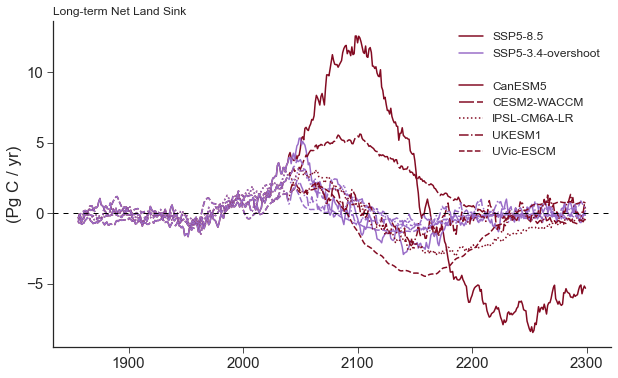

In [17]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, nbp_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, nbp_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend(linelist, labels_list, frameon=False)

plt.savefig('land_flux_timeseries.png', dpi=300, format='png')

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


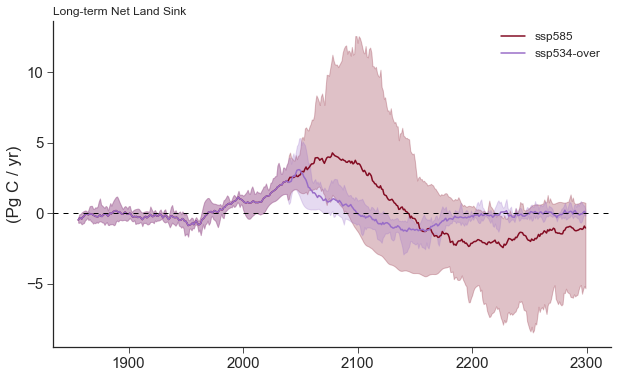

In [18]:
### plot ensemble mean and ranges across full ensemble

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, nbp_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,0,:].min(dim='models'), nbp_trajectories_2exp[:,0,:].max(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, nbp_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,1,:].min(dim='models'), nbp_trajectories_2exp[:,1,:].max(dim='models'), color=ssp534os_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2], exps_list[1:], frameon=False)



/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


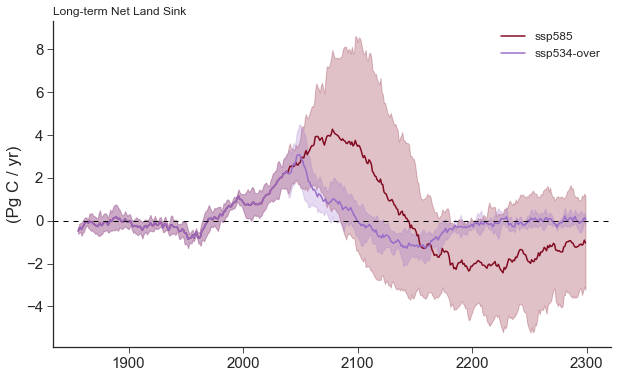

In [19]:
### plot ensemble mean and ranges, using plus/minus one standard deviation

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, nbp_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,0,:].mean(dim='models')-nbp_trajectories_2exp[:,0,:].std(dim='models'), nbp_trajectories_2exp[:,0,:].mean(dim='models')+nbp_trajectories_2exp[:,0,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, nbp_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,1,:].mean(dim='models')-nbp_trajectories_2exp[:,1,:].std(dim='models'), nbp_trajectories_2exp[:,1,:].mean(dim='models')+nbp_trajectories_2exp[:,1,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2], exps_list[1:], frameon=False)



/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


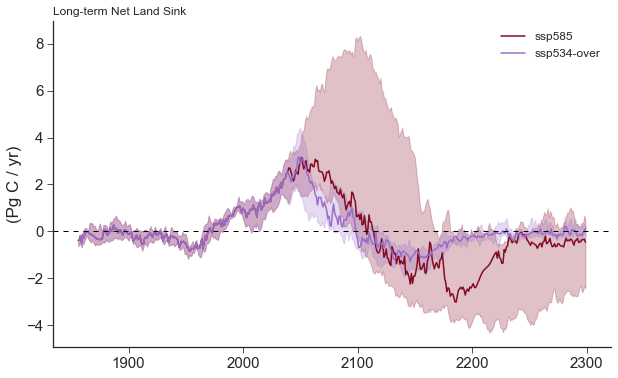

In [20]:
### plot ensemble median and 15-85%ile range

ax = plt.subplot(111)

transparency=0.25
envelope_quantile = 0.15

a1, = ax.plot(years, nbp_trajectories_2exp[:,0,:].median(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,0,:].quantile(envelope_quantile, dim='models'), nbp_trajectories_2exp[:,0,:].quantile(1.-envelope_quantile, dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, nbp_trajectories_2exp[:,1,:].median(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, nbp_trajectories_2exp[:,1,:].quantile(envelope_quantile, dim='models'), nbp_trajectories_2exp[:,1,:].quantile(1.-envelope_quantile, dim='models'), color=ssp534os_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2], exps_list[1:], frameon=False)




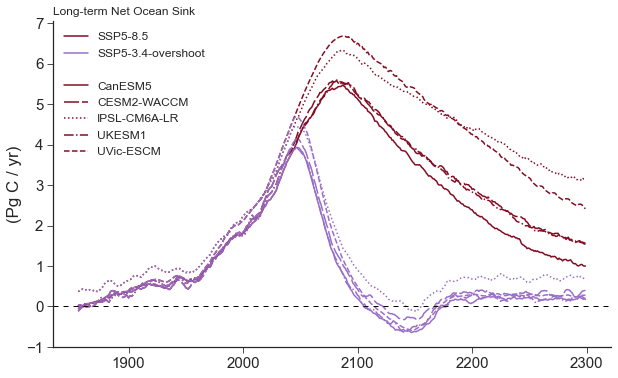

In [21]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, fgco2_trajectories_2exp[model_i,0,:], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, fgco2_trajectories_2exp[model_i,1,:], color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)
        
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)
plt.savefig('ocean_flux_timeseries.png', dpi=300, format='png')

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


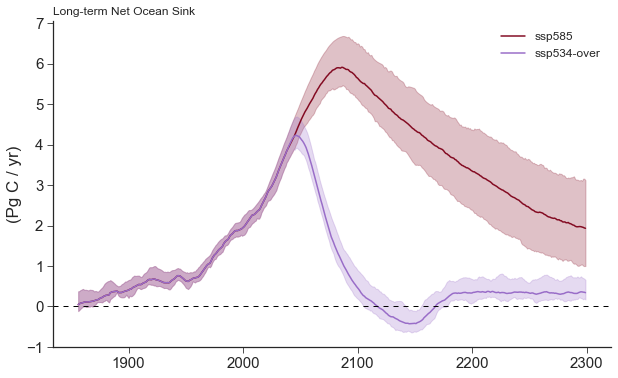

In [22]:
### plot ensemble mean and ranges, using full ensemble

ax = plt.subplot(111)

transparency=0.25

a1, = ax.plot(years, fgco2_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,0,:].min(dim='models'), fgco2_trajectories_2exp[:,0,:].max(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, fgco2_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,1,:].min(dim='models'), fgco2_trajectories_2exp[:,1,:].max(dim='models'), color=ssp534os_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2], exps_list[1:], frameon=False)




/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


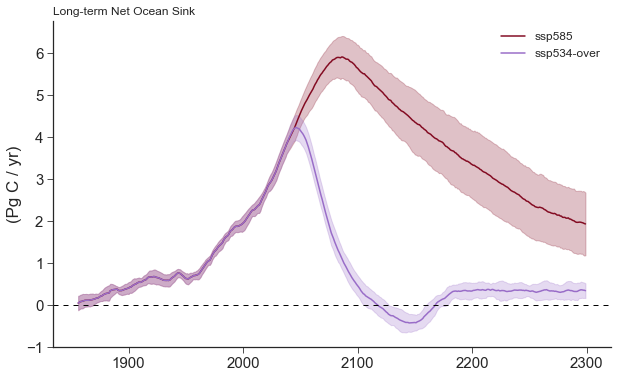

In [23]:
### plot ensemble mean and plus / minus one standard deviation

ax = plt.subplot(111)

transparency=0.25
envelope_quantile = 0.15

a1, = ax.plot(years, fgco2_trajectories_2exp[:,0,:].mean(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,0,:].mean(dim='models')-fgco2_trajectories_2exp[:,0,:].std(dim='models'), fgco2_trajectories_2exp[:,0,:].mean(dim='models')+fgco2_trajectories_2exp[:,0,:].std(dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, fgco2_trajectories_2exp[:,1,:].mean(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,1,:].mean(dim='models')-fgco2_trajectories_2exp[:,1,:].std(dim='models'), fgco2_trajectories_2exp[:,1,:].mean(dim='models')+fgco2_trajectories_2exp[:,1,:].std(dim='models'), color=ssp534os_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2], exps_list[1:], frameon=False)




/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


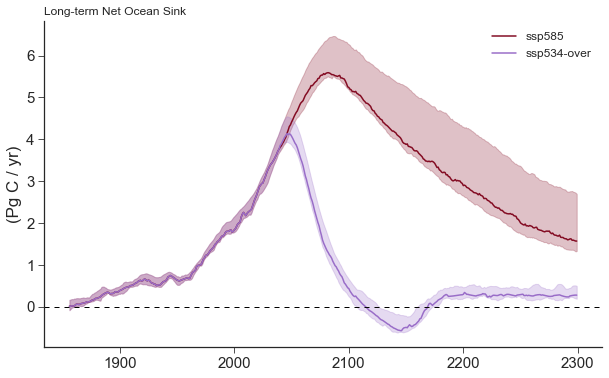

In [24]:
### plot ensemble median and 15th-8th percentile ranges

ax = plt.subplot(111)

transparency=0.25
envelope_quantile = 0.15

a1, = ax.plot(years, fgco2_trajectories_2exp[:,0,:].median(dim='models'), color=ssp585_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,0,:].quantile(envelope_quantile, dim='models'), fgco2_trajectories_2exp[:,0,:].quantile(1.-envelope_quantile, dim='models'), color=ssp585_color, alpha=transparency)

a2, = ax.plot(years, fgco2_trajectories_2exp[:,1,:].median(dim='models'), color=ssp534os_color)
f1 = ax.fill_between(years, fgco2_trajectories_2exp[:,1,:].quantile(envelope_quantile, dim='models'), fgco2_trajectories_2exp[:,1,:].quantile(1.-envelope_quantile, dim='models'), color=ssp534os_color, alpha=transparency)

    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.legend([a1,a2], exps_list[1:], frameon=False)




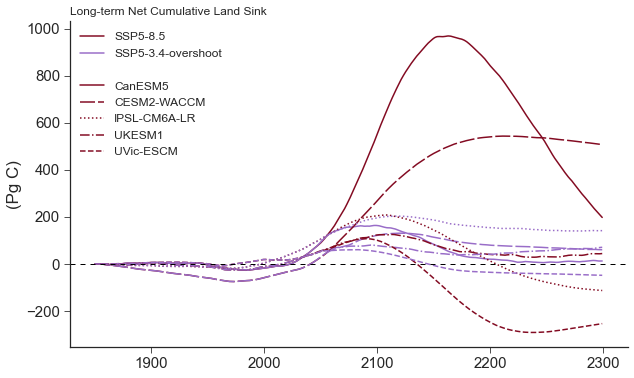

In [25]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, nbp_trajectories_2exp[model_i,0,:].cumsum(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, nbp_trajectories_2exp[model_i,1,:].cumsum(), color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)
   
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C)')
plt.title('Long-term Net Cumulative Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)


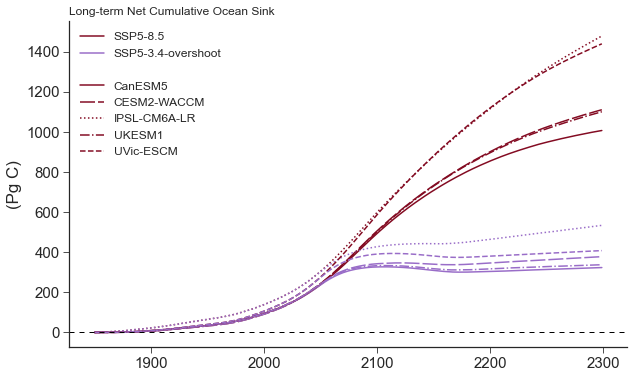

In [26]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, fgco2_trajectories_2exp[model_i,0,:].cumsum(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, fgco2_trajectories_2exp[model_i,1,:].cumsum(), color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C)')
plt.title('Long-term Net Cumulative Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)


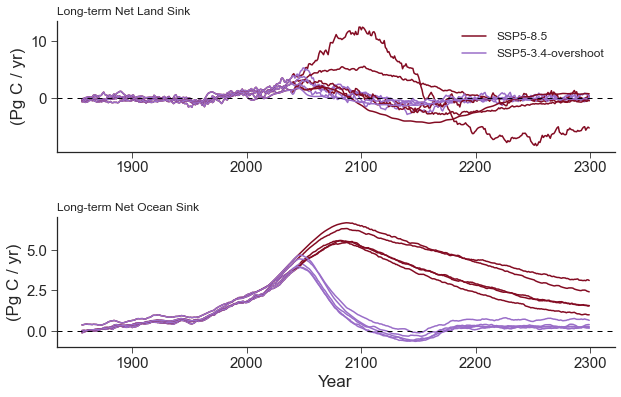

In [27]:
ax = plt.subplot(211)

for model_i in range(nmodels):
    ax.plot(years, nbp_trajectories_2exp[model_i,0,:], color=ssp585_color)
    ax.plot(years, nbp_trajectories_2exp[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

ax = plt.subplot(212)
plt.subplots_adjust(hspace=0.5)


for model_i in range(nmodels):
    ax.plot(years, fgco2_trajectories_2exp[model_i,0,:], color=ssp585_color)
    ax.plot(years, fgco2_trajectories_2exp[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')
plt.xlabel('Year')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)



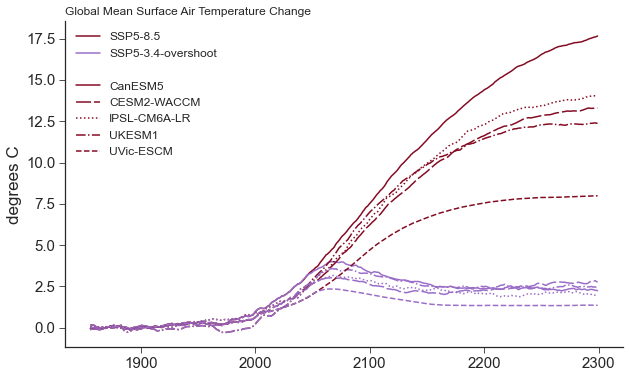

In [28]:
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)

plt.savefig('global_temperature_timeseries.png', dpi=300, format='png')

### zonal mean analyses

In [29]:
### first concatenate the zonal mean plots so they  are from 1850-2300 and have the ssps sequantially after the historical
#exps_list = ('historical','ssp585','ssp534-over')
zonal_mean_anual_nbp_list_concatenated = []
for model_i in range(nmodels):
    zonal_mean_anual_nbp_list_concatenated.append([])
    if type(zonal_mean_anual_nbp_list[model_i][0]) != type(None):
        ## first put a None in place of the historical for these
        zonal_mean_anual_nbp_list_concatenated[model_i].append(None)  
        ## next put the historical + ssp5585
        zonalmean_nbp_ts_cat = xr.concat((zonal_mean_anual_nbp_list[model_i][exps_list.index('historical')],zonal_mean_anual_nbp_list[model_i][exps_list.index('ssp585')]), dim='time')
        zonal_mean_anual_nbp_list_concatenated[model_i].append(zonalmean_nbp_ts_cat)
        ## next put the historical + first part of ssp5585 + ssp534os
        zonalmean_nbp_ts_cat = xr.concat((zonal_mean_anual_nbp_list[model_i][exps_list.index('historical')],zonal_mean_anual_nbp_list[model_i][exps_list.index('ssp585')].isel(time=slice(0,25)),zonal_mean_anual_nbp_list[model_i][exps_list.index('ssp534-over')]), dim='time')
        zonal_mean_anual_nbp_list_concatenated[model_i].append(zonalmean_nbp_ts_cat)
    else:
        zonal_mean_anual_nbp_list_concatenated[model_i].append([None,None,None])

In [30]:
zonalmean_figsize = (10, 8)

In [31]:
#carbon_colormap = 'RdBu'
carbon_colormap = 'PiYG'
#carbon_colormap = 'PRGn'

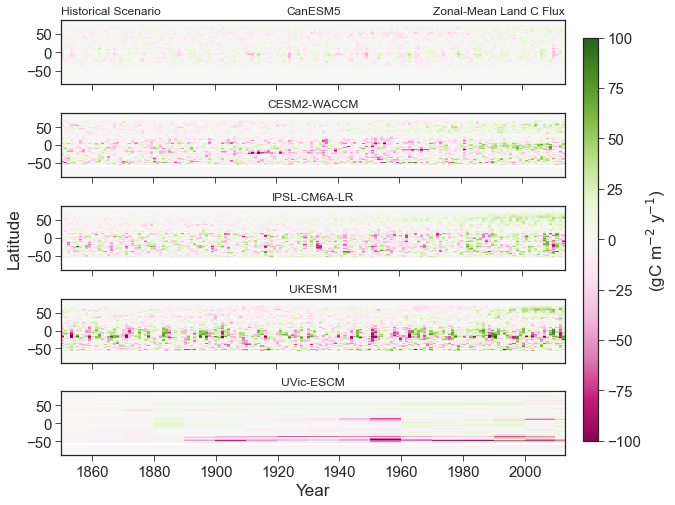

In [32]:
### plot zonal-mean fields of NBP over time
max_val = 100 #saturating color in g C / m2 / yr
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_nbp_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list[model_i][0].time))+1850, zonal_mean_anual_nbp_list[model_i][0].lat, zonal_mean_anual_nbp_list[model_i][0].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean Land C Flux', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(gC m$^{-2}$ y$^{-1}$)')

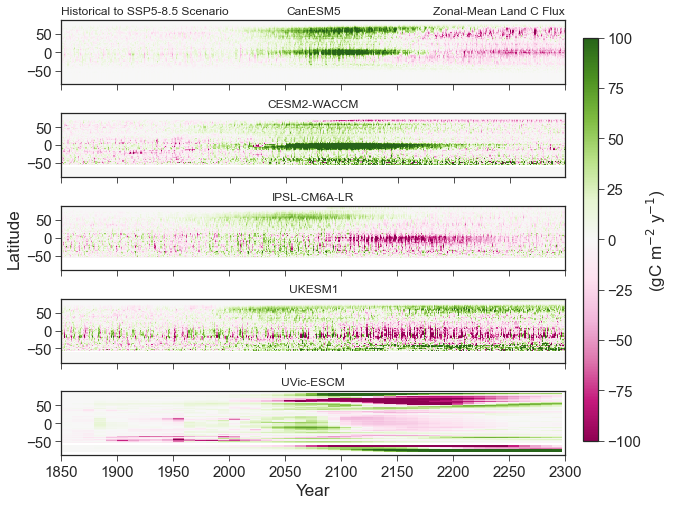

In [33]:
## then SSP5-8.5

fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_nbp_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list_concatenated[model_i][1].time))+1850, zonal_mean_anual_nbp_list_concatenated[model_i][1].lat, zonal_mean_anual_nbp_list_concatenated[model_i][1].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-8.5 Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean Land C Flux', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(gC m$^{-2}$ y$^{-1}$)')
fig.savefig('ssp585_land_cflux.png', dpi=300, format='png')

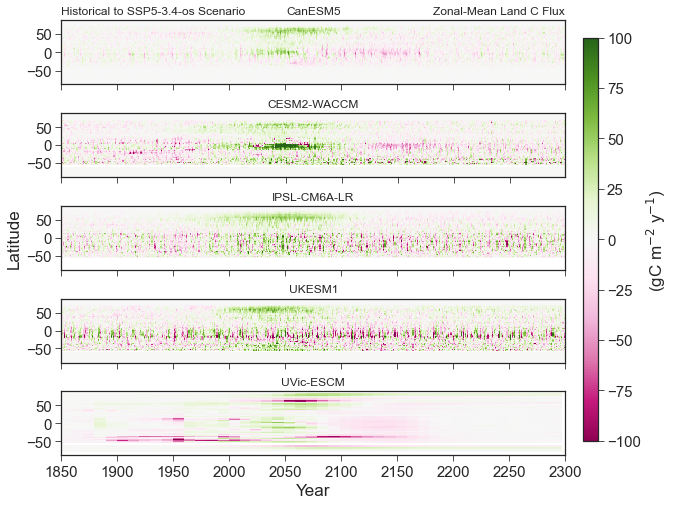

In [34]:
## then SSP5-3.4-OS

fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_nbp_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list_concatenated[model_i][2].time))+1850, zonal_mean_anual_nbp_list_concatenated[model_i][2].lat, zonal_mean_anual_nbp_list_concatenated[model_i][2].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-3.4-os Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean Land C Flux', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(gC m$^{-2}$ y$^{-1}$)')
fig.savefig('ssp534os_land_cflux.png', dpi=300, format='png')

In [35]:
### first concatenate the zonal mean plots so they  are from 1850-2300 and have the ssps sequantially after the historical
#exps_list = ('historical','ssp585','ssp534-over')
if make_zonal_mean_fgco2_plots:
    zonal_mean_anual_fgco2_list_concatenated = []
    for model_i in range(nmodels):
        if type(zonal_mean_anual_fgco2_list[model_i*3]) != type(None):
            ## first put a None in place of the historical for these
            zonal_mean_anual_fgco2_list_concatenated.append(None)  
            ## next put the historical + ssp5585
            zonalmean_fgco2_ts_cat = xr.concat((zonal_mean_anual_fgco2_list[model_i*3],zonal_mean_anual_fgco2_list[model_i*3+1]), dim='time')
            #print(zonalmean_fgco2_ts_cat)
            zonal_mean_anual_fgco2_list_concatenated.append(zonalmean_fgco2_ts_cat)
            ## next put the historical + first part of ssp5585 + ssp534os
            zonalmean_fgco2_ts_cat = xr.concat((zonal_mean_anual_fgco2_list[model_i*3],zonal_mean_anual_fgco2_list[model_i*3+1].isel(time=slice(0,25)),zonal_mean_anual_fgco2_list[model_i*3+2]), dim='time')
            zonal_mean_anual_fgco2_list_concatenated.append(zonalmean_fgco2_ts_cat)
        else:
            zonal_mean_anual_fgco2_list_concatenated.append(None)

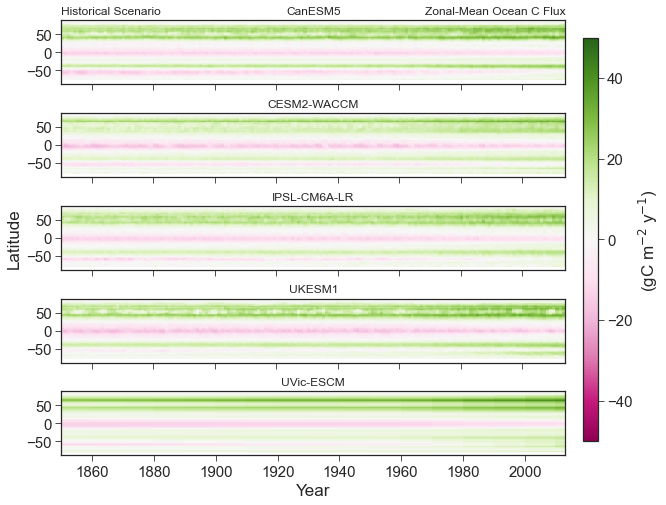

In [36]:
### plot zonal-mean fields of fgco2 over time
if make_zonal_mean_fgco2_plots:
    max_val = 50 #saturating color in g C / m2 / yr

    # first the historical simulation
    ### plot zonal-mean fields of fgco2 over time
    fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
    idx = -1
    for model_i in range(nmodels):
        if type(zonal_mean_anual_fgco2_list[model_i*3]) != type(None):
            idx = idx+1
            c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_fgco2_list[idx*3].time))+1850, lat_bin_centers_for_fgco2_zonalmean_plots, zonal_mean_anual_fgco2_list[idx*3]*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap=carbon_colormap)
            if idx == 0:
                axs[idx].set_title('Historical Scenario', loc='left')
                axs[idx].set_title('Zonal-Mean Ocean C Flux', loc='right')
            if idx == 2:
                axs[idx].set_ylabel('Latitude')
            if idx == n_gridded:
                axs[idx].set_xlabel('Year')
            else:
                axs[idx].xaxis.set_tick_params(labelbottom=False)
            axs[idx].set_title(models_list[model_i])
    fig.subplots_adjust(hspace=0.45)
    fig.subplots_adjust(right=0.825)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    b = fig.colorbar(c, cax=cbar_ax)
    b.set_label('(gC m$^{-2}$ y$^{-1}$)')

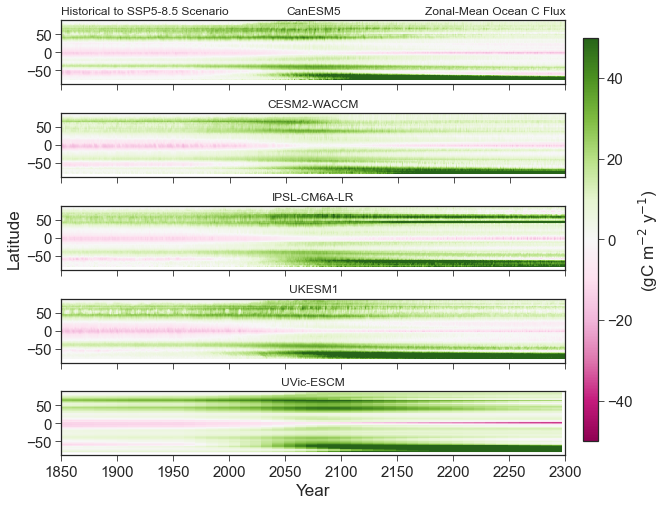

In [37]:
# then the SSP5-8.5 simulation
if make_zonal_mean_fgco2_plots:
    fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
    idx = -1
    for model_i in range(nmodels):
        if type(zonal_mean_anual_fgco2_list[model_i*3]) != type(None):
            idx = idx+1
            c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_fgco2_list_concatenated[idx*3+1].time))+1850, lat_bin_centers_for_fgco2_zonalmean_plots, zonal_mean_anual_fgco2_list_concatenated[idx*3+1]*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap=carbon_colormap)
            if idx == 0:
                axs[idx].set_title('Historical to SSP5-8.5 Scenario', loc='left')
                axs[idx].set_title('Zonal-Mean Ocean C Flux', loc='right')
            if idx == 2:
                axs[idx].set_ylabel('Latitude')
            if idx == n_gridded:
                axs[idx].set_xlim(right=2300)
                axs[idx].set_xlabel('Year')
            else:
                axs[idx].xaxis.set_tick_params(labelbottom=False)
            axs[idx].set_title(models_list[model_i])
    fig.subplots_adjust(hspace=0.45)
    fig.subplots_adjust(right=0.825)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    b = fig.colorbar(c, cax=cbar_ax)
    b.set_label('(gC m$^{-2}$ y$^{-1}$)')
    fig.savefig('ssp585_ocean_cflux.png', dpi=300, format='png')

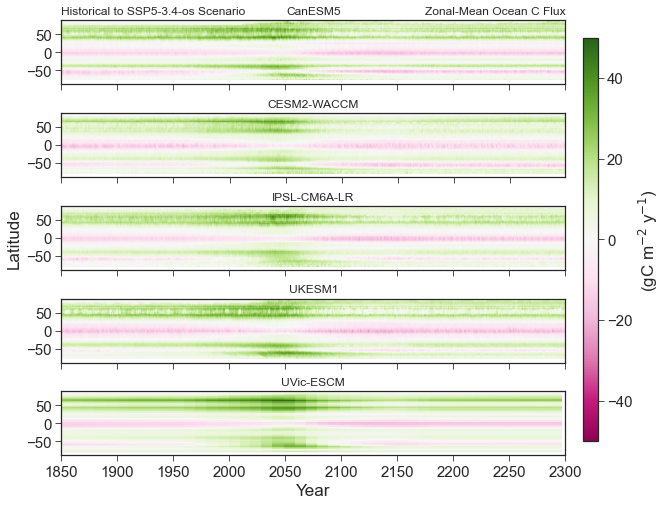

In [38]:
# then the SSP5-3.4-OS simulation
### plot zonal-mean fields of fgco2 over time
if make_zonal_mean_fgco2_plots:
    fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
    idx = -1
    for model_i in range(nmodels):
        if type(zonal_mean_anual_fgco2_list[model_i*3]) != type(None):
            idx = idx+1
            c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_fgco2_list_concatenated[idx*3+2].time))+1850, lat_bin_centers_for_fgco2_zonalmean_plots, zonal_mean_anual_fgco2_list_concatenated[idx*3+2]*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap=carbon_colormap)
            if idx == 0:
                axs[idx].set_title('Historical to SSP5-3.4-os Scenario', loc='left')
                axs[idx].set_title('Zonal-Mean Ocean C Flux', loc='right')
            if idx == 2:
                axs[idx].set_ylabel('Latitude')
            if idx == n_gridded:
                axs[idx].set_xlim(right=2300)
                axs[idx].set_xlabel('Year')
            else:
                axs[idx].xaxis.set_tick_params(labelbottom=False)
            axs[idx].set_title(models_list[model_i])
    fig.subplots_adjust(hspace=0.45)
    fig.subplots_adjust(right=0.825)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    b = fig.colorbar(c, cax=cbar_ax)
    b.set_label('(gC m$^{-2}$ y$^{-1}$)')
    fig.savefig('ssp534os_ocean_cflux.png', dpi=300, format='png')

In [39]:
### first concatenate the zonal mean plots so they  are from 1850-2300 and have the ssps sequantially after the historical
#exps_list = ('historical','ssp585','ssp534-over')
zonal_mean_tas_list_concatenated = []
for model_i in range(nmodels):
    zonal_mean_tas_list_concatenated.append([])
    if type(zonal_mean_tas_list[model_i][0]) != type(None):
        ## first put a None in place of the historical for these
        zonal_mean_tas_list_concatenated[model_i].append(None)  
        ## next put the historical + ssp5585
        zonalmean_tas_ts_cat = xr.concat((zonal_mean_tas_list[model_i][exps_list.index('historical')],zonal_mean_tas_list[model_i][exps_list.index('ssp585')]), dim='time')
        zonal_mean_tas_list_concatenated[model_i].append(zonalmean_tas_ts_cat)
        ## next put the historical + first part of ssp5585 + ssp534os
        zonalmean_tas_ts_cat = xr.concat((zonal_mean_tas_list[model_i][exps_list.index('historical')],zonal_mean_tas_list[model_i][exps_list.index('ssp585')].isel(time=slice(0,25)),zonal_mean_tas_list[model_i][exps_list.index('ssp534-over')]), dim='time')
        zonal_mean_tas_list_concatenated[model_i].append(zonalmean_tas_ts_cat)
    else:
        zonal_mean_tas_list_concatenated[model_i].append([None,None,None])


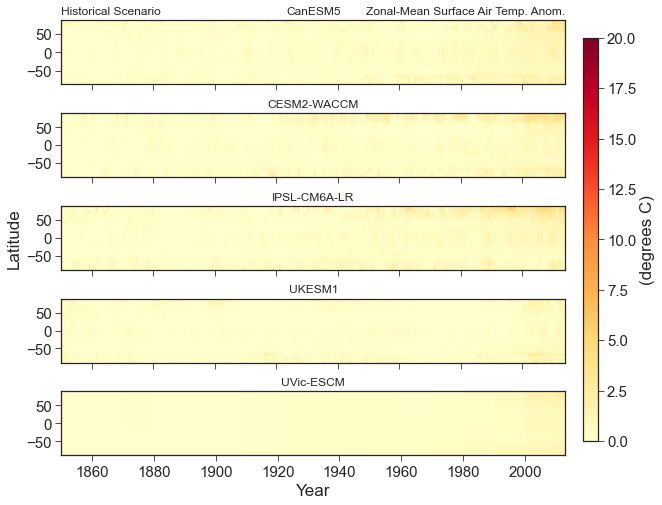

In [40]:
### plot zonal-mean fields of tas over time
max_val = 20. #saturating color in degrees C
min_val = 0 #saturating color in degrees C

n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_tas_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_tas_list[model_i][0].time))+1850, zonal_mean_tas_list[model_i][0].lat, (zonal_mean_tas_list[model_i][0] - zonal_mean_tas_list[model_i][0][0:years_to_average_gmst,:].mean(dim='time')).transpose(), rasterized=True, vmin=min_val, vmax=max_val, cmap='YlOrRd')
        if idx == 0:
            axs[idx].set_title('Historical Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean Surface Air Temp. Anom.', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(degrees C)')

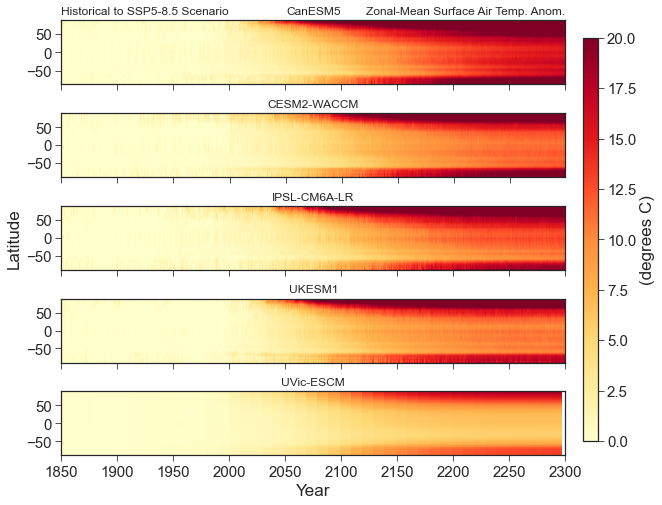

In [41]:
### plot zonal-mean fields of tas over time

n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_tas_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_tas_list_concatenated[model_i][1].time))+1850, zonal_mean_tas_list_concatenated[model_i][1].lat, (zonal_mean_tas_list_concatenated[model_i][1] - zonal_mean_tas_list_concatenated[model_i][1][0:years_to_average_gmst,:].mean(dim='time')).transpose(), rasterized=True, vmin=min_val, vmax=max_val, cmap='YlOrRd')
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-8.5 Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean Surface Air Temp. Anom.', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(degrees C)')
fig.savefig('ssp585_temp.png', dpi=300, format='png')

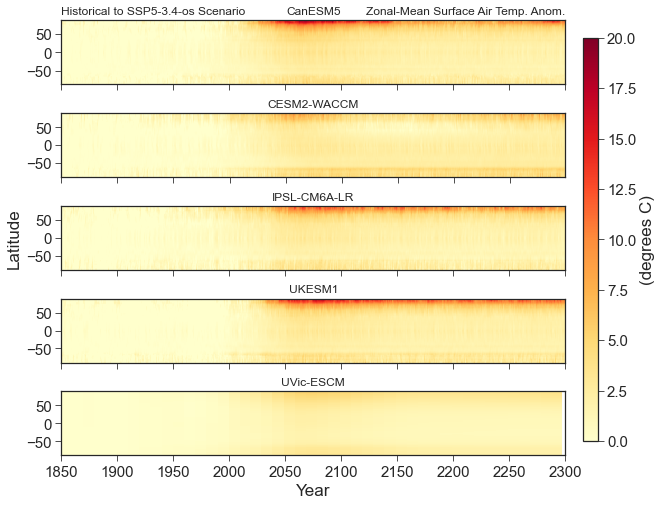

In [42]:
### plot zonal-mean fields of tas over time

n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_tas_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_tas_list_concatenated[model_i][2].time))+1850, zonal_mean_tas_list_concatenated[model_i][2].lat, (zonal_mean_tas_list_concatenated[model_i][2] - zonal_mean_tas_list_concatenated[model_i][2][0:years_to_average_gmst,:].mean(dim='time')).transpose(), rasterized=True, vmin=min_val, vmax=max_val, cmap='YlOrRd')
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-3.4-os Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean Surface Air Temp. Anom.', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(degrees C)')
fig.savefig('ssp534os_temp.png', dpi=300, format='png')

In [43]:
### first concatenate the zonal mean plots so they  are from 1850-2300 and have the ssps sequantially after the historical
#exps_list = ('historical','ssp585','ssp534-over')
zonal_mean_anual_cVeg_list_concatenated = []
for model_i in range(nmodels):
    zonal_mean_anual_cVeg_list_concatenated.append([])
    if type(zonal_mean_anual_cVeg_list[model_i][0]) != type(None):
        ## first put a None in place of the historical for these
        zonal_mean_anual_cVeg_list_concatenated[model_i].append(None)  
        ## next put the historical + ssp5585
        zonalmean_tas_ts_cat = xr.concat((zonal_mean_anual_cVeg_list[model_i][exps_list.index('historical')],zonal_mean_anual_cVeg_list[model_i][exps_list.index('ssp585')]), dim='time')
        zonal_mean_anual_cVeg_list_concatenated[model_i].append(zonalmean_tas_ts_cat)
        ## next put the historical + first part of ssp5585 + ssp534os
        zonalmean_tas_ts_cat = xr.concat((zonal_mean_anual_cVeg_list[model_i][exps_list.index('historical')],zonal_mean_anual_cVeg_list[model_i][exps_list.index('ssp585')].isel(time=slice(0,25)),zonal_mean_anual_cVeg_list[model_i][exps_list.index('ssp534-over')]), dim='time')
        zonal_mean_anual_cVeg_list_concatenated[model_i].append(zonalmean_tas_ts_cat)
    else:
        zonal_mean_anual_cVeg_list_concatenated[model_i].append([None,None,None])


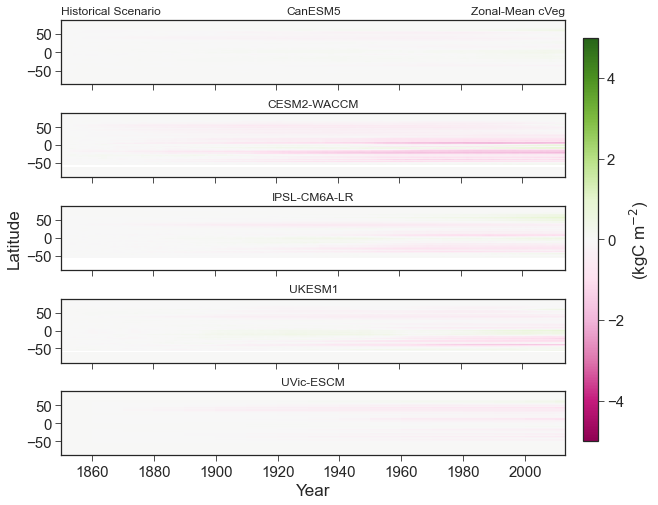

In [44]:
### plot zonal-mean fields of cVeg over time
max_val_cveg = 5 #saturating color in g C / m2 
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_cVeg_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_cVeg_list[model_i][0].time))+1850, zonal_mean_anual_cVeg_list[model_i][0].lat, zonal_mean_anual_cVeg_list[model_i][0].transpose()-zonal_mean_anual_cVeg_list[model_i][0].isel(time=0), rasterized=True, vmin=-max_val_cveg, vmax=max_val_cveg, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean cVeg', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(kgC m$^{-2}$)')

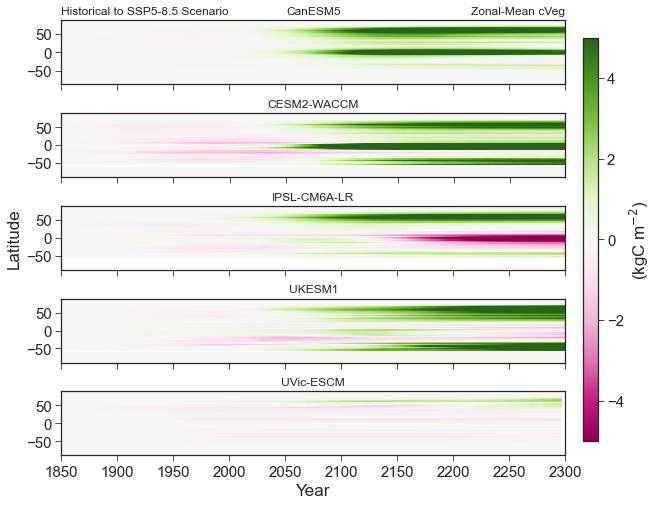

In [45]:
### plot zonal-mean fields of cVeg over time
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_cVeg_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_cVeg_list_concatenated[model_i][1].time))+1850, zonal_mean_anual_cVeg_list_concatenated[model_i][1].lat, zonal_mean_anual_cVeg_list_concatenated[model_i][1].transpose()-zonal_mean_anual_cVeg_list_concatenated[model_i][1].isel(time=0), rasterized=True, vmin=-max_val_cveg, vmax=max_val_cveg, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-8.5 Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean cVeg', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(kgC m$^{-2}$)')
fig.savefig('ssp585_cveg.png', dpi=300, format='png')

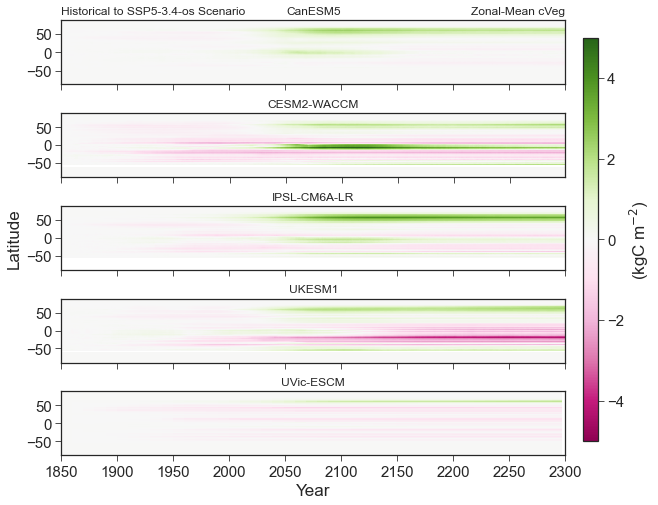

In [46]:
### plot zonal-mean fields of cVeg over time
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_cVeg_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_cVeg_list_concatenated[model_i][2].time))+1850, zonal_mean_anual_cVeg_list_concatenated[model_i][2].lat, zonal_mean_anual_cVeg_list_concatenated[model_i][2].transpose()-zonal_mean_anual_cVeg_list_concatenated[model_i][2].isel(time=0), rasterized=True, vmin=-max_val_cveg, vmax=max_val_cveg, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-3.4-os Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean cVeg', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(kgC m$^{-2}$)')
fig.savefig('ssp534os_cveg.png', dpi=300, format='png')

In [47]:
### first concatenate the zonal mean plots so they  are from 1850-2300 and have the ssps sequantially after the historical
#exps_list = ('historical','ssp585','ssp534-over')
zonal_mean_anual_cSoil_list_concatenated = []
for model_i in range(nmodels):
    zonal_mean_anual_cSoil_list_concatenated.append([])
    if type(zonal_mean_anual_cSoil_list[model_i][0]) != type(None):
        ## first put a None in place of the historical for these
        zonal_mean_anual_cSoil_list_concatenated[model_i].append(None)  
        ## next put the historical + ssp5585
        zonalmean_tas_ts_cat = xr.concat((zonal_mean_anual_cSoil_list[model_i][exps_list.index('historical')],zonal_mean_anual_cSoil_list[model_i][exps_list.index('ssp585')]), dim='time')
        zonal_mean_anual_cSoil_list_concatenated[model_i].append(zonalmean_tas_ts_cat)
        ## next put the historical + first part of ssp5585 + ssp534os
        zonalmean_tas_ts_cat = xr.concat((zonal_mean_anual_cSoil_list[model_i][exps_list.index('historical')],zonal_mean_anual_cSoil_list[model_i][exps_list.index('ssp585')].isel(time=slice(0,25)),zonal_mean_anual_cSoil_list[model_i][exps_list.index('ssp534-over')]), dim='time')
        zonal_mean_anual_cSoil_list_concatenated[model_i].append(zonalmean_tas_ts_cat)
    else:
        zonal_mean_anual_cSoil_list_concatenated[model_i].append([None,None,None])

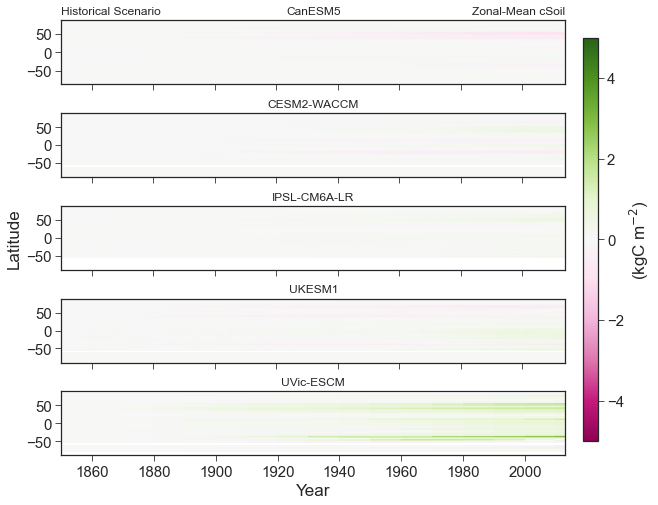

In [48]:
### plot zonal-mean fields of cSoil over time
max_val_csoil = max_val_cveg #saturating color in g C / m2 
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_cSoil_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_cSoil_list[model_i][0].time))+1850, zonal_mean_anual_cSoil_list[model_i][0].lat, zonal_mean_anual_cSoil_list[model_i][0].transpose()-zonal_mean_anual_cSoil_list[model_i][0].isel(time=0), rasterized=True, vmin=-max_val_csoil, vmax=max_val_csoil, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean cSoil', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(kgC m$^{-2}$)')

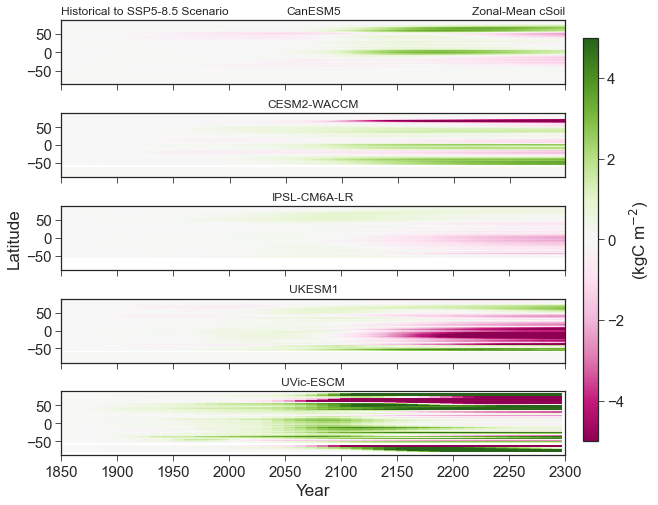

In [49]:
### plot zonal-mean fields of cSoil over time
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_cSoil_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_cSoil_list_concatenated[model_i][1].time))+1850, zonal_mean_anual_cSoil_list_concatenated[model_i][1].lat, zonal_mean_anual_cSoil_list_concatenated[model_i][1].transpose()-zonal_mean_anual_cSoil_list_concatenated[model_i][1].isel(time=0), rasterized=True, vmin=-max_val_csoil, vmax=max_val_csoil, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-8.5 Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean cSoil', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(kgC m$^{-2}$)')
fig.savefig('ssp585_csoil.png', dpi=300, format='png')

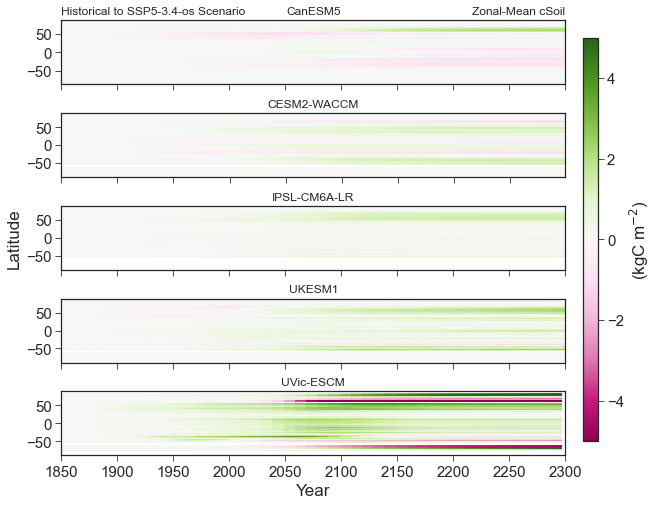

In [50]:
### plot zonal-mean fields of cSoil over time
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1

## first historical        
fig, axs = plt.subplots(n_gridded+1, figsize=zonalmean_figsize)
idx = -1
for model_i in range(nmodels):
    if type(zonal_mean_anual_cSoil_list[model_i][0]) != type(None):
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_cSoil_list_concatenated[model_i][2].time))+1850, zonal_mean_anual_cSoil_list_concatenated[model_i][2].lat, zonal_mean_anual_cSoil_list_concatenated[model_i][2].transpose()-zonal_mean_anual_cSoil_list_concatenated[model_i][2].isel(time=0), rasterized=True, vmin=-max_val_csoil, vmax=max_val_csoil, cmap=carbon_colormap)
        if idx == 0:
            axs[idx].set_title('Historical to SSP5-3.4-os Scenario', loc='left')
            axs[idx].set_title('Zonal-Mean cSoil', loc='right')
        if idx == 2:
            axs[idx].set_ylabel('Latitude')
        if idx == n_gridded:
            axs[idx].set_xlim(right=2300)
            axs[idx].set_xlabel('Year')
        else:
            axs[idx].xaxis.set_tick_params(labelbottom=False)
        axs[idx].set_title(models_list[model_i])
fig.subplots_adjust(hspace=0.45)
fig.subplots_adjust(right=0.825)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
b = fig.colorbar(c, cax=cbar_ax)
b.set_label('(kgC m$^{-2}$)')
fig.savefig('ssp534os_csoil.png', dpi=300, format='png')

In [51]:
## now load the atmospheric mole fraction of co2 to calculate the cumulative emissions
filename_atmco2_hist = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc'
filename_atmco2_ssp585 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp534os = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc'

tmin_co2mf_hist = 0
tmin_co2mf_ssps = 2015


#startyear_exps = [1850, 2015, 2040]
#endyear_exps = [2014, 2299, 2299]

co2_mf_ts = xr.DataArray(np.ma.masked_all((2,nyears_total)), dims=['scenarios','time'])

co2_molefrac_hist = xr.open_dataset(filename_atmco2_hist, decode_times=False)
hist_co2_ts = co2_molefrac_hist['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[0]-tmin_co2mf_hist,endyear_exps[0]-tmin_co2mf_hist+1))
co2_mf_ts[:,0:endyear_exps[0]-startyear_exps[0]+1] = hist_co2_ts

co2_molefrac_ssp585 = xr.open_dataset(filename_atmco2_ssp585, decode_times=False)
ssp585_co2_ts = co2_molefrac_ssp585['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts[0,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp585_co2_ts

co2_molefrac_ssp534os = xr.open_dataset(filename_atmco2_ssp534os, decode_times=False)
ssp534os_co2_ts = co2_molefrac_ssp534os['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts[1,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp534os_co2_ts

#co2_mf_ts.plot()


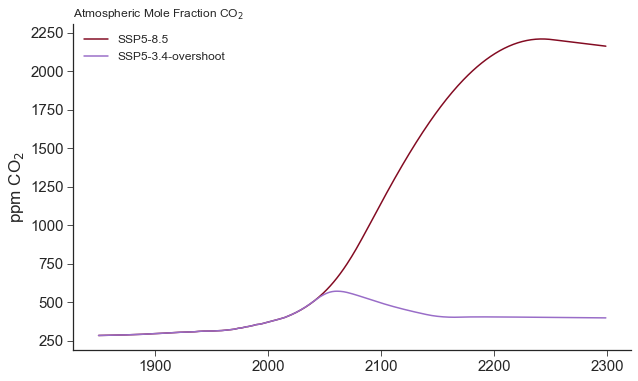

In [52]:
ax = plt.subplot(111)

ax.plot(years, co2_mf_ts[0,:], color=ssp585_color)
ax.plot(years, co2_mf_ts[1,:], color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('ppm CO$_2$')
plt.title('Atmospheric Mole Fraction CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)
plt.savefig('co2_timeseries.png', dpi=300, format='png')

In [53]:
### now calculate cumulative emissions
ppm_to_pgc = 2.124  # from le quere 2018, which gets it from ballantyne et al 2012

atm_co2_pgc = (co2_mf_ts - co2_mf_ts.isel(time=0)) * ppm_to_pgc
cum_land_carbon_pgc = nbp_trajectories_2exp.cumsum(dim='time')
cum_ocn_carbon_pgc = fgco2_trajectories_2exp.cumsum(dim='time')

cum_emissions_pgc = atm_co2_pgc + cum_land_carbon_pgc + cum_ocn_carbon_pgc

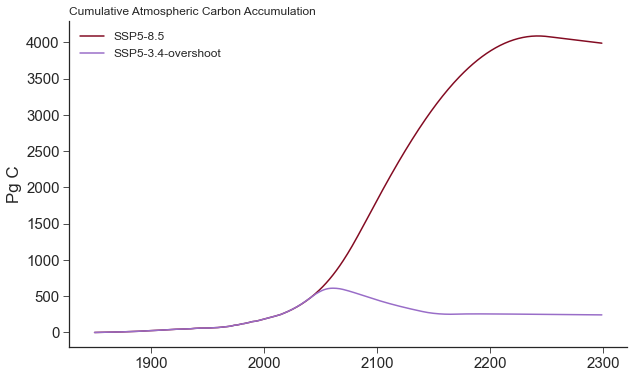

In [54]:
ax = plt.subplot(111)

ax.plot(years, atm_co2_pgc[0,:], color=ssp585_color)
ax.plot(years, atm_co2_pgc[1,:], color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Pg C')
plt.title('Cumulative Atmospheric Carbon Accumulation',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


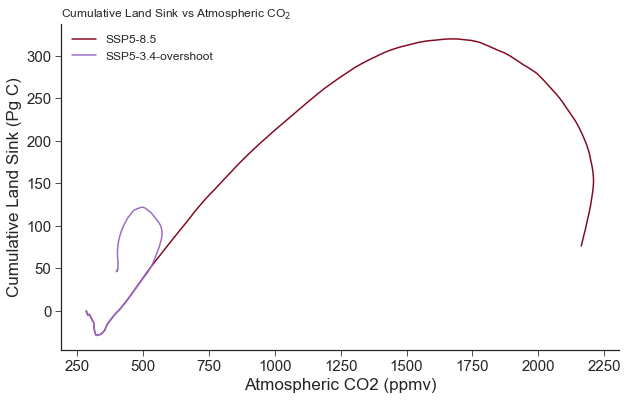

In [55]:
### playing around with some other ways of plotting things
ax = plt.subplot(111)

#ax.plot(cum_emissions_pgc[0,:].mean(dim='models'),nbp_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
#ax.plot(cum_emissions_pgc[1,:].mean(dim='models'),nbp_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)

ax.plot(co2_mf_ts[0,:],nbp_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
ax.plot(co2_mf_ts[1,:],nbp_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)


#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Cumulative Land Sink (Pg C)')
plt.xlabel('Atmospheric CO2 (ppmv)')
plt.title('Cumulative Land Sink vs Atmospheric CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


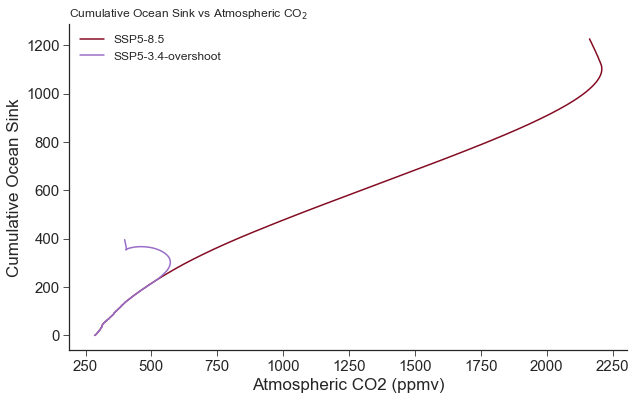

In [56]:
### playing around with some other ways of plotting things
ax = plt.subplot(111)

#ax.plot(cum_emissions_pgc[0,:].mean(dim='models'),fgco2_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
#ax.plot(cum_emissions_pgc[1,:].mean(dim='models'),fgco2_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)

ax.plot(co2_mf_ts[0,:],fgco2_trajectories_2exp[:,0,:].mean(dim='models').cumsum(), color=ssp585_color)
ax.plot(co2_mf_ts[1,:],fgco2_trajectories_2exp[:,1,:].mean(dim='models').cumsum(), color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Cumulative Ocean Sink')
plt.xlabel('Atmospheric CO2 (ppmv)')
plt.title('Cumulative Ocean Sink vs Atmospheric CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

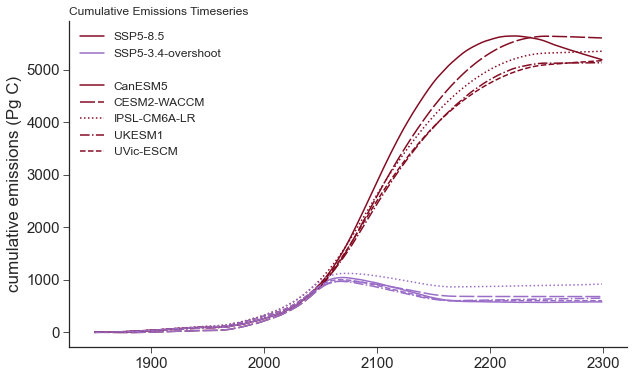

In [57]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, cum_emissions_pgc[0,:, model_i], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, cum_emissions_pgc[1,:, model_i], color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('cumulative emissions (Pg C)')
#plt.xlabel('Year')
plt.title('Cumulative Emissions Timeseries',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)
plt.savefig('cumulative_emissions_timeseries.png', dpi=300, format='png')

(2, 450, 5)


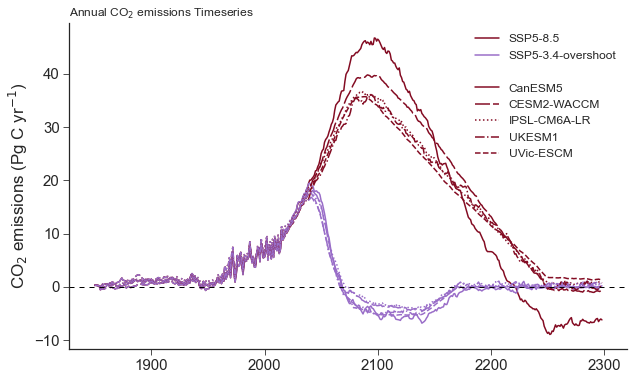

In [58]:
ax = plt.subplot(111)
print(cum_emissions_pgc.shape)
annual_emissions_pgc = cum_emissions_pgc.copy()
annual_emissions_pgc[:,-1,:] = None
annual_emissions_pgc[:,:-1,:] = np.diff(cum_emissions_pgc, axis=1)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, annual_emissions_pgc[0,:, model_i], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, annual_emissions_pgc[1,:, model_i], color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ emissions (Pg C yr$^{-1}$)')
#plt.xlabel('Year')
plt.title('Annual CO$_2$ emissions Timeseries',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)

In [59]:
### read in co2 emission sdata from IAM extensions
iam_emissions_filename = 'rcmip-emissions-annual-means-v5-1-0.csv'
iam_emissions_file = pd.read_csv(iam_emissions_filename)

ssp534os_co2emiss = iam_emissions_file[(iam_emissions_file.Scenario == 'ssp534-over') * (iam_emissions_file.Variable == 'Emissions|CO2|MAGICC Fossil and Industrial') * (iam_emissions_file.Region == 'World')]
ssp585_co2emiss = iam_emissions_file[(iam_emissions_file.Scenario == 'ssp585') * (iam_emissions_file.Variable == 'Emissions|CO2|MAGICC Fossil and Industrial') * (iam_emissions_file.Region == 'World')]

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [60]:
iam_emissions = xr.DataArray(np.ma.masked_all((2,nyears_total)), dims=['scenarios','time'], coords=[np.arange(2), np.arange(nyears_total)+1850.])

iam_emissions[0,:] = ssp534os_co2emiss.iloc[0,107:557]
iam_emissions[1,:] = ssp585_co2emiss.iloc[0,107:557]

In [61]:
iam_emissions_nomissing = iam_emissions.dropna(dim='time')

(2, 450, 5)


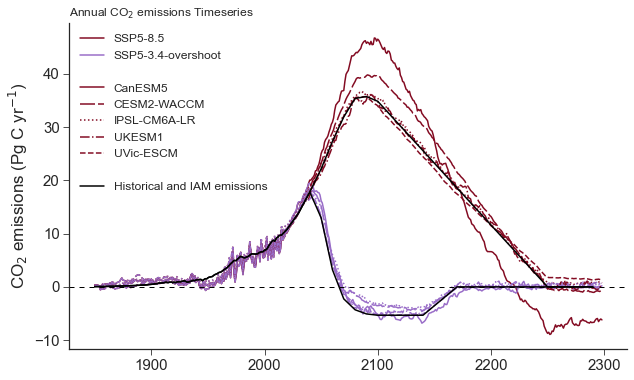

In [62]:
ax = plt.subplot(111)
print(cum_emissions_pgc.shape)
annual_emissions_pgc = cum_emissions_pgc.copy()
annual_emissions_pgc[:,-1,:] = None
annual_emissions_pgc[:,:-1,:] = np.diff(cum_emissions_pgc, axis=1)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(years, annual_emissions_pgc[0,:, model_i], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(years, annual_emissions_pgc[1,:, model_i], color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

a3, = ax.plot(iam_emissions_nomissing.time, iam_emissions_nomissing[0,:]*1e-3 * 12/44, color='black')        
ax.plot(iam_emissions_nomissing.time, iam_emissions_nomissing[1,:]*1e-3 * 12/44, color='black')        


ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ emissions (Pg C yr$^{-1}$)')
#plt.xlabel('Year')
plt.title('Annual CO$_2$ emissions Timeseries',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

linelist_wiam = list(linelist)
labels_list_wiam = list(labels_list)

linelist_wiam.append(emptyline)
labels_list_wiam.append(None)

linelist_wiam.append(a3)
labels_list_wiam.append('Historical and IAM emissions')



plt.legend(linelist_wiam, labels_list_wiam, frameon=False)
plt.savefig('annual_emissions_timeseries.png', dpi=300, format='png')

In [63]:
atm_accumulation = atm_co2_pgc.copy()
atm_accumulation[:,1:] = np.diff(atm_co2_pgc, axis=1)
atm_accumulation = atm_accumulation.rolling(time=nyear_smooth).mean()
esm_emissions_ensmean = annual_emissions_pgc.mean(dim='models').rolling(time=nyear_smooth).mean()

lnd_flux_ensmean = nbp_trajectories_2exp.mean(dim='models').rolling(time=nyear_smooth).mean()
ocn_flux_ensmean = fgco2_trajectories_2exp.mean(dim='models').rolling(time=nyear_smooth).mean()


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


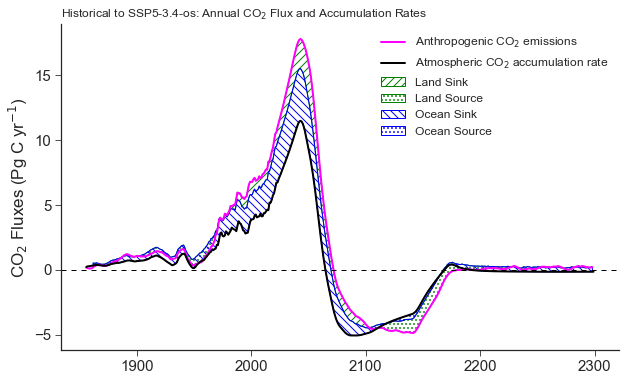

In [64]:
ax = plt.subplot(111)

scen_i = 1

a1, = ax.plot(years, esm_emissions_ensmean[scen_i,:], color='magenta', linewidth=2.)
a2, = ax.plot(years, atm_accumulation[scen_i,:], color='black', linewidth=2.)
a3 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='///', where=(lnd_flux_ensmean[scen_i,:] >= 0.))
a4 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='...', where=(lnd_flux_ensmean[scen_i,:] <= 0.))
a5 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='\\\\\\', where=(ocn_flux_ensmean[scen_i,:] >= 0.))
a6 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='...', where=(ocn_flux_ensmean[scen_i,:] <= 0.))

linelist = [a1,a2,a3,a4,a5,a6]
labels_list = ['Anthropogenic CO$_2$ emissions', 'Atmospheric CO$_2$ accumulation rate', 'Land Sink', 'Land Source', 'Ocean Sink', 'Ocean Source']

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ Fluxes (Pg C yr$^{-1}$)')
#plt.xlabel('Year')
plt.title('Historical to SSP5-3.4-os: Annual CO$_2$ Flux and Accumulation Rates',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)
plt.savefig('ssp534os_fluxes_all.png', dpi=300, format='png')

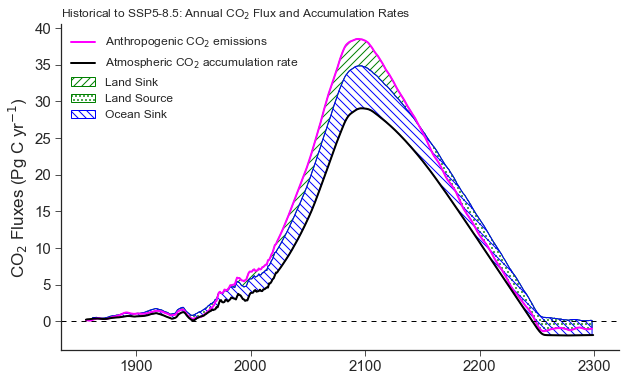

In [65]:
ax = plt.subplot(111)

scen_i = 0

a1, = ax.plot(years, esm_emissions_ensmean[scen_i,:], color='magenta', linewidth=2.)
a2, = ax.plot(years, atm_accumulation[scen_i,:], color='black', linewidth=2.)
a3 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='///', where=(lnd_flux_ensmean[scen_i,:] >= 0.))
a4 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:], esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], facecolor='none', edgecolor='green', hatch='...', where=(lnd_flux_ensmean[scen_i,:] <= 0.))
a5 = ax.fill_between(years, esm_emissions_ensmean[scen_i,:] - lnd_flux_ensmean[scen_i,:], atm_accumulation[scen_i,:], facecolor='none', edgecolor='blue', hatch='\\\\\\', where=(ocn_flux_ensmean[scen_i,:] >= 0.))

linelist = [a1,a2,a3,a4,a5]
labels_list = ['Anthropogenic CO$_2$ emissions', 'Atmospheric CO$_2$ accumulation rate', 'Land Sink', 'Land Source', 'Ocean Sink']

ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('CO$_2$ Fluxes (Pg C yr$^{-1}$)')
#plt.xlabel('Year')
plt.title('Historical to SSP5-8.5: Annual CO$_2$ Flux and Accumulation Rates',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)
plt.savefig('ssp585_fluxes_all.png', dpi=300, format='png')

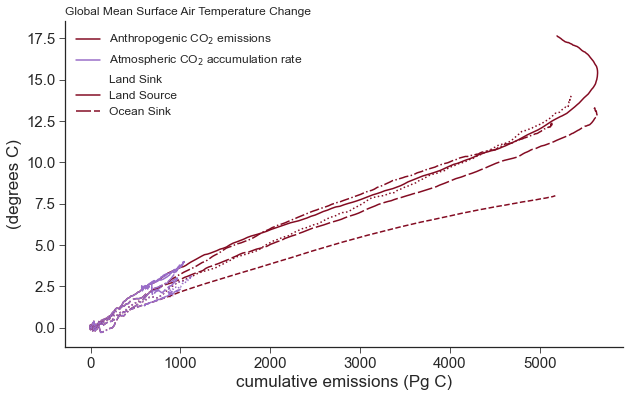

In [66]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(cum_emissions_pgc[0,:, model_i], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([2050,2050], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)
plt.savefig('temp_vs_cumulative_emissions_both_ssps.png', dpi=300, format='png')

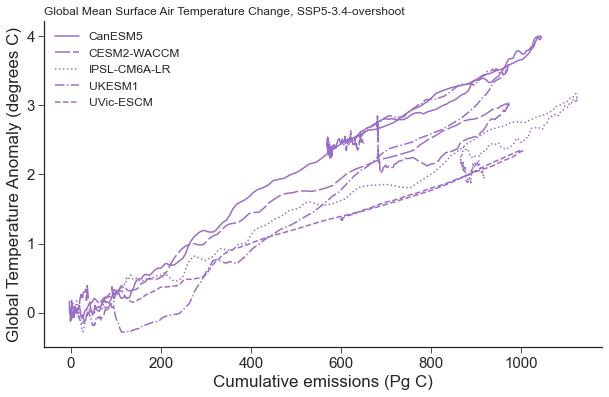

In [67]:
### just show the SSP5-3.4os
ax = plt.subplot(111)

linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    linelist.append(a1)

emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Global Temperature Anomaly (degrees C)')
plt.xlabel('Cumulative emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-3.4-overshoot',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, models_list, frameon=False)

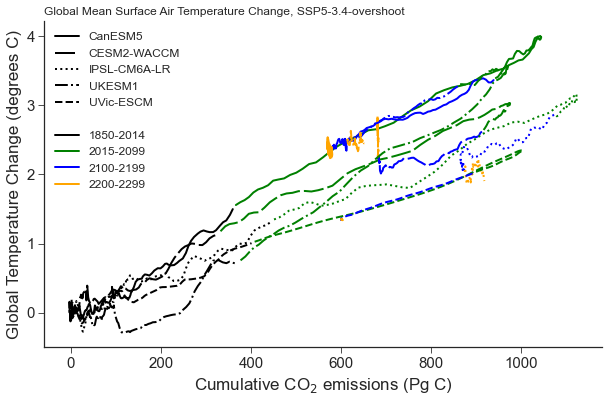

In [68]:
### just show the SSP5-3.4os, but color based on the century
ax = plt.subplot(111)

period_list = ['1850-2014','2015-2099','2100-2199','2200-2299']
period_tstart = np.array([1850,2015,2100,2200], dtype=np.int)-1850
period_tend = np.array([2015,2100,2200,2300], dtype=np.int)-1850
colors = ['black','green','blue','orange']
linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[1,period_tstart[period_i]:period_tend[period_i], model_i], tas_trajectories_2exp[model_i,1,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=colors[period_i], linestyle=dashlist[model_i], linewidth=2.)
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Global Temperature Change (degrees C)')
plt.xlabel('Cumulative CO$_2$ emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-3.4-overshoot',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False)
plt.savefig('temp_vs_cumulative_emissions_ssp534os_bycentury.png', dpi=300, format='png')

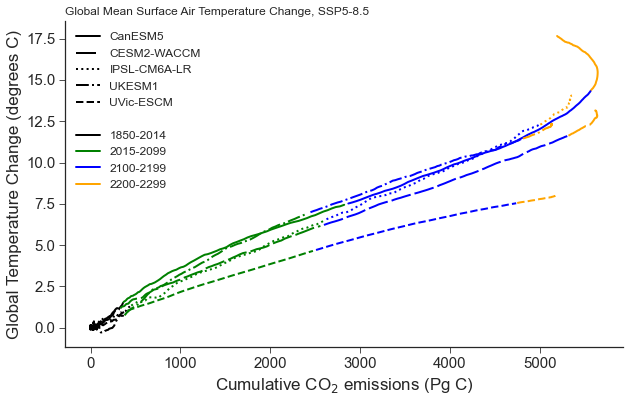

In [69]:
### just show the SSP5-8.5, but color based on the century
ax = plt.subplot(111)

linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[0,period_tstart[period_i]:period_tend[period_i], model_i], tas_trajectories_2exp[model_i,0,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=colors[period_i], linestyle=dashlist[model_i], linewidth=2.)
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)


#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('Global Temperature Change (degrees C)')
plt.xlabel('Cumulative CO$_2$ emissions (Pg C)')
plt.title('Global Mean Surface Air Temperature Change, SSP5-8.5',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False)
plt.savefig('temp_vs_cumulative_emissions_ssp585_bycentury.png', dpi=300, format='png')

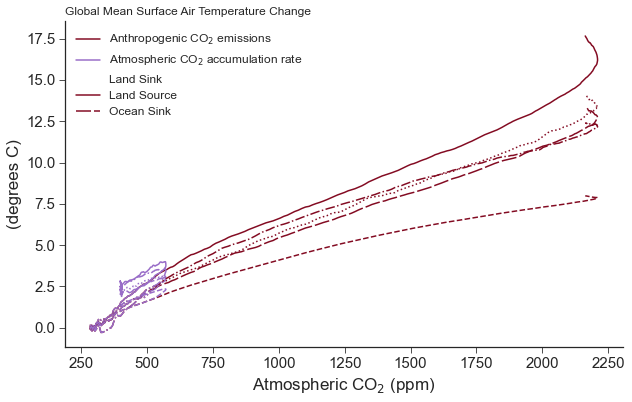

In [70]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(co2_mf_ts[0,:], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([500,500], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)



#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Atmospheric CO$_2$ (ppm)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)


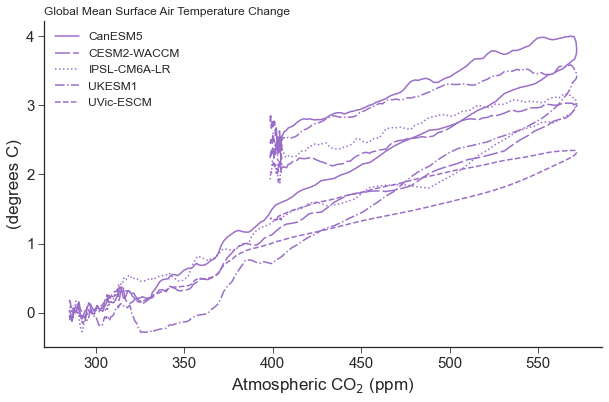

In [71]:
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(co2_mf_ts[1,:], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color, linestyle=dashlist[model_i])
    linelist.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('Atmospheric CO$_2$ (ppm)')
plt.title('Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, models_list, frameon=False)




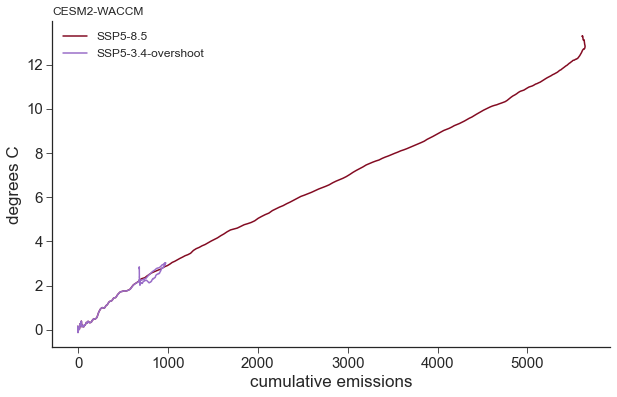

In [72]:
### look at any one model on its own...
model_i = models_list.index('CESM2-WACCM')

ax = plt.subplot(111)
ax.plot(cum_emissions_pgc[0,:, model_i], tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp585_color)
ax.plot(cum_emissions_pgc[1,:, model_i], tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean(), color=ssp534os_color)
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.xlabel('cumulative emissions')
plt.title(models_list[model_i],loc='left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


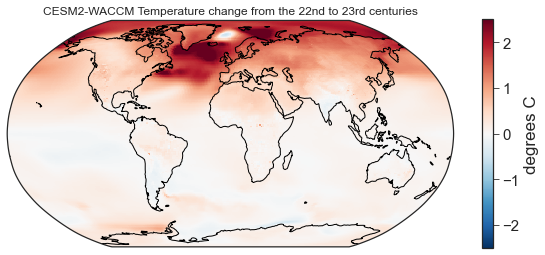

In [73]:
## curious about the spatial pattern associated with the 23rd-century T increase in CESM2-WACCM under SSP5-3.4-os
cesm2_tas_ssp534os = xr.open_mfdataset(file_master_list_dynamics[models_list.index('CESM2-WACCM')][vars_list.index('tas')][exps_list.index('ssp534-over')])
tas_annual = monthly_to_annual(cesm2_tas_ssp534os['tas'])
tas_annual_21cmean = tas_annual[0:60,:,:].mean(dim='time')
tas_annual_22cmean = tas_annual[60:160,:,:].mean(dim='time')
tas_annual_23cmean = tas_annual[160:260,:,:].mean(dim='time')
#(tas_annual_23cmean - tas_annual_22cmean).plot()


proj = ccrs.Robinson()
ax = plt.axes(projection=proj)
plt.title("CESM2-WACCM Temperature change from the 22nd to 23rd centuries")

tdiff = (tas_annual_23cmean - tas_annual_22cmean)
tdiff_ext, lon_ext = add_cyclic_point(tdiff, coord=tdiff.lon)
fig = plt.pcolormesh(lon_ext, tdiff.lat, tdiff_ext, vmin=-2.5, vmax=2.5, cmap='RdBu_r', transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(fig, orientation="vertical", shrink=0.7)
cbar.set_label('degrees C')

plt.savefig('cesm2_23rd_minus_22nd_century_temp_map.png', dpi=300, format='png')


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'msftmz' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


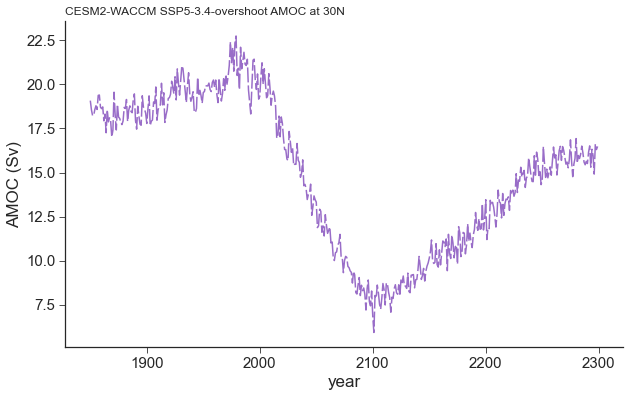

In [74]:
### due to CESM2-WACCM's interesting behavior in the SSP5-3.4-os scenario, 
### want to test the hypothesis that the warming trends are caused by trends in the AMOC

msftmz_cesm2_hist = xr.open_mfdataset('msftmz_Omon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc')
msftmz_cesm2_ssp585 = xr.open_mfdataset('msftmz_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_*.nc')
msftmz_cesm2_ssp534os = xr.open_mfdataset('msftmz_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_*.nc')
msftmz_atl_var_hist = msftmz_cesm2_hist.msftmz.isel(basin=0)
msftmz_atl_var_ssp585 = msftmz_cesm2_ssp585.msftmz.isel(basin=0)
msftmz_atl_var_ssp534os = msftmz_cesm2_ssp534os.msftmz.isel(basin=0)
msftmz_atl_var_annual_hist = monthly_to_annual(msftmz_atl_var_hist)
msftmz_atl_var_annual_ssp585 = monthly_to_annual(msftmz_atl_var_ssp585)
msftmz_atl_var_annual_ssp534os = monthly_to_annual(msftmz_atl_var_ssp534os)
#msftmz_atl_var_annual.mean(dim='time').plot()
lat_amoc = 30.
ind_lat_amoc = np.argmin(np.abs(msftmz_atl_var_annual_ssp534os.lat - lat_amoc).data)
amoc_hist = msftmz_atl_var_annual_hist.isel(lat=ind_lat_amoc).max(dim='lev')
amoc_ssp585 = msftmz_atl_var_annual_ssp585.isel(lat=ind_lat_amoc).max(dim='lev')
amoc_ssp534os = msftmz_atl_var_annual_ssp534os.isel(lat=ind_lat_amoc).max(dim='lev')

amoc_ssp585_to2040 = amoc_ssp585[0:25]
amoc_ts = xr.concat((amoc_hist,amoc_ssp585_to2040,amoc_ssp534os), dim='time')

kg_per_sec__to__sv = 1e-9
model_i = models_list.index('CESM2-WACCM')
ax = plt.subplot(111)
#a1, = ax.plot(np.arange(len(amoc_hist))+1850., amoc_hist*kg_per_sec__to__sv, color=ssp534os_color, linestyle=dashlist[model_i])
#a2, = ax.plot(np.arange(len(amoc_ssp585_to2040))+2015., amoc_ssp585_to2040*kg_per_sec__to__sv, color=ssp534os_color, linestyle=dashlist[model_i])
#a3, = ax.plot(np.arange(len(amoc_ssp534os))+2040., amoc_ssp534os*kg_per_sec__to__sv, color=ssp534os_color, linestyle=dashlist[model_i])
a1, = ax.plot(np.arange(len(amoc_ts))+1850., amoc_ts*kg_per_sec__to__sv, color=ssp534os_color, linestyle=dashlist[model_i])



plt.ylabel('AMOC (Sv)')
plt.xlabel('year')
plt.title('CESM2-WACCM SSP5-3.4-overshoot AMOC at 30N',loc='left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(, frameon=False)
plt.savefig('cesm2_ssp534os_amoc_timeseries.png', dpi=300, format='png')

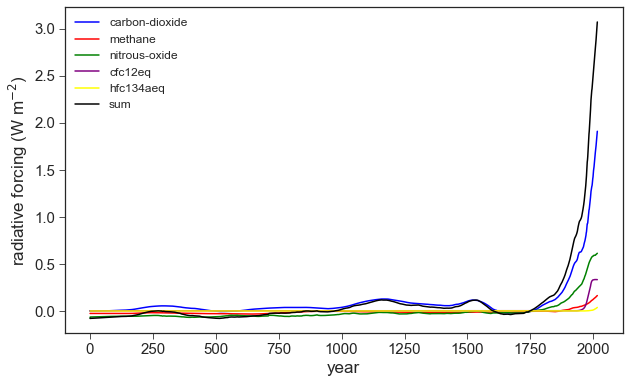

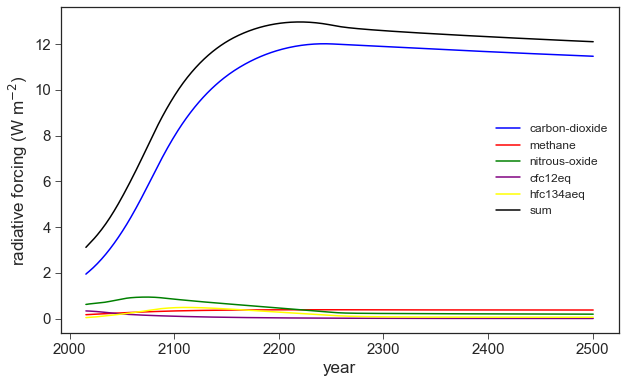

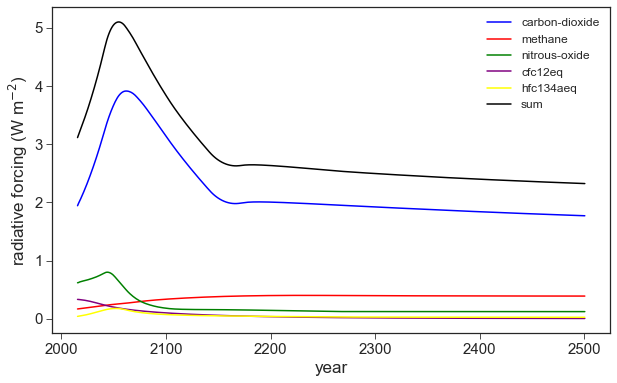

In [75]:
### i want to be able to calculate the co2-attributable warming, which equals warming * RF_CO2 / RF_total
#ghg_list_long = ['c-c4f8','c2f6','c3f8','c4f10','c5f12','c6f14','c7f16','c8f18','carbon-dioxide','carbon-tetrachloride','cf4','cfc11','cfc113','cfc114','cfc115','cfc11eq','cfc12','cfc12eq','ch2cl2','ch3ccl3','chcl3','halon1211','halon1301','halon2402','hcfc141b','hcfc142b','hcfc22','hfc125','hfc134a','hfc134aeq','hfc143a','hfc152a','hfc227ea','hfc23','hfc236fa','hfc245fa','hfc32','hfc365mfc','hfc4310mee','methane','methyl-bromide','methyl-chloride','nf3','nitrous-oxide','sf6','so2f2']
ghg_list_short = ['carbon-dioxide','methane','nitrous-oxide','cfc12eq','hfc134aeq']

scenario_filename_suffixes = ['-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc',
                              '-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc',
                              '-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc']
filename_prefix = 'mole-fraction-of-'

### define some functions to calculate radiative forcing.  use table 3 of meinshausen et al 2019
def calc_rf_co2(co2, n2o):
    camax = 1808.   # ppm
    c0 = 277.15     # ppm
    a1 = -2.4785e-7 # W m-2 ppm-2
    b1 = 0.00075906 # W m-2 ppm-1
    c1 = -0.0021492 # W m-2 ppb -0.5
    d1 = 5.2488     # W m-2
    aprime = co2.copy()  # make a dataarray with same shape and indices as co2
    for i in range(len(co2)):
        if co2[i] > camax:
            aprime[i] = d1 - b1**2/(4*a1)
        elif co2[i] < c0:
            aprime[i] = d1
        else:
            aprime[i] = d1 + a1 * (co2[i] - c0)**2 + b1*(co2[i] - c0)
    alpha_n2o = c1 * np.sqrt(n2o)
    return((aprime + alpha_n2o) * np.log(co2/c0))
    
def calc_rf_n2o(co2, n2o, methane):
    a2 = -0.00034197  # W m-2 ppm-1
    b2 = 0.00025455   # W m-2 ppb-1
    c2 = -0.00024357  # W m-2 ppb-1
    d2 = 0.12173      # W m-2 ppb-0.5
    N0 = 273.87       # ppb
    return((a2*np.sqrt(co2)+b2*np.sqrt(n2o)+c2*np.sqrt(methane)+d2)*(np.sqrt(n2o)-np.sqrt(N0)))

def calc_rf_methane(methane, n2o):
    a3 = -8.9603e-05 #W m-2 ppb-1 
    b3 = -0.00012462 #W m-2 ppb-1 
    d3 = 0.045194    #W m-2 ppb-0.5 
    M0 = 731.41      #ppb
    return((a3*np.sqrt(methane)+b3*np.sqrt(n2o)+d3)*(np.sqrt(methane)-np.sqrt(M0)))

radiative_efficiency_hfc134a = 0.16  ## W m-1 ppb-1 from IPCC AR5 table 8.A.1
radiative_efficiency_cfc12   = 0.32  ## W m-1 ppb-1 from IPCC AR5 table 8.A.1

sector = 0

attrib_frac = []

colors = ['blue','red','green','purple','yellow', 'black']

time_startdate_ghgts = [0,1850,1850]

for scen_i, scen in enumerate(scenario_filename_suffixes):
    files_list = []
    for ghg in ghg_list_short:
        files_list.append(xr.open_dataset(filename_prefix+ghg+scen, decode_times=False))
    mf_co2 = files_list[ghg_list_short.index('carbon-dioxide')].isel(sector=sector)['mole_fraction_of_carbon_dioxide_in_air']
    mf_ch4 = files_list[ghg_list_short.index('methane')].isel(sector=sector)['mole_fraction_of_methane_in_air']
    mf_n2o = files_list[ghg_list_short.index('nitrous-oxide')].isel(sector=sector)['mole_fraction_of_nitrous_oxide_in_air']
    mf_cfc12eq = files_list[ghg_list_short.index('cfc12eq')].isel(sector=sector)['mole_fraction_of_cfc12eq_in_air']
    mf_hfc134aeq = files_list[ghg_list_short.index('hfc134aeq')].isel(sector=sector)['mole_fraction_of_hfc134aeq_in_air']
    #
    rf_co2 = calc_rf_co2(mf_co2, mf_n2o)
    rf_n2o = calc_rf_n2o(mf_co2, mf_n2o, mf_ch4)
    rf_ch4 = calc_rf_methane(mf_ch4, mf_n2o)
    rf_cfc12eq = mf_cfc12eq * radiative_efficiency_cfc12 * 1e-3  # reported in ppt but radiative efficiency in ppb
    rf_hfc134aeq = mf_hfc134aeq * radiative_efficiency_hfc134a * 1e-3  # reported in ppt but radiative efficiency in ppb
    #
    rf_sum = (rf_co2 + rf_n2o + rf_ch4 + rf_cfc12eq + rf_hfc134aeq)
    #
    co2_attributable_fraction_warming = rf_co2 / rf_sum
    attrib_frac.append(co2_attributable_fraction_warming)
    ax = plt.subplot(111)

    l1, = ax.plot(rf_co2.time/365.+time_startdate_ghgts[scen_i], rf_co2.data, color=colors[0])
    l2, = ax.plot(rf_n2o.time/365.+time_startdate_ghgts[scen_i], rf_n2o.data, color=colors[1])
    l3, = ax.plot(rf_ch4.time/365.+time_startdate_ghgts[scen_i], rf_ch4.data, color=colors[2])
    l4, = ax.plot(rf_cfc12eq.time/365.+time_startdate_ghgts[scen_i], rf_cfc12eq.data, color=colors[3])
    l5, = ax.plot(rf_hfc134aeq.time/365.+time_startdate_ghgts[scen_i], rf_hfc134aeq.data, color=colors[4])
    l6, = ax.plot(rf_sum.time/365.+time_startdate_ghgts[scen_i], rf_sum.data, color=colors[5])
    plt.xlabel('year')
    plt.ylabel('radiative forcing (W m$^{-2}$)')
    plt.legend(ghg_list_short+['sum'], frameon=False)
    plt.show()




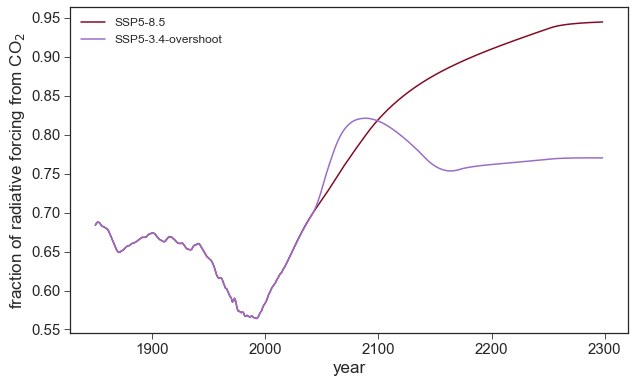

In [76]:
# put the co2 fraction of radiative forcing onto same dimensions as surface temperature anomalies
co2attributable_rf = xr.DataArray(np.ma.masked_all([n_future_scens,nyears_total]), dims=["scenarios", "time"])

co2attributable_rf[:,0:startyear_exps[1]-startyear_exps[0]] = attrib_frac[0][startyear_exps[0]:endyear_exps[0]+1]
co2attributable_rf[0,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]] = attrib_frac[1][0:endyear_exps[1]-startyear_exps[1]]
co2attributable_rf[1,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]] = attrib_frac[2][0:endyear_exps[1]-startyear_exps[1]]

ax = plt.subplot(111)
linelist = []
linelist.append(ax.plot(years, co2attributable_rf[0,:], color=ssp585_color))
linelist.append(ax.plot(years, co2attributable_rf[1,:], color=ssp534os_color))
plt.xlabel('year')
plt.ylabel('fraction of radiative forcing from CO$_2$')
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)


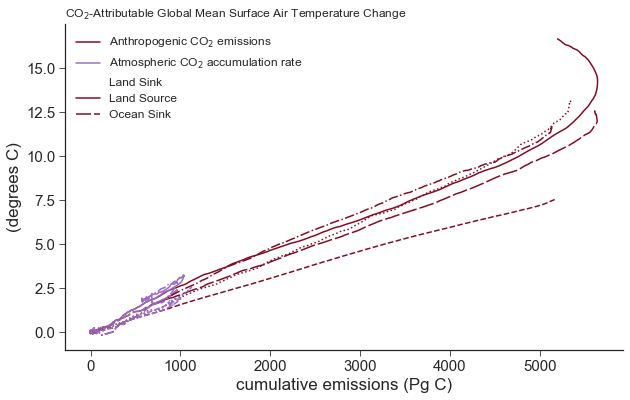

In [77]:
### now remake the cumulative emissions figure but only for co2-attributable warming
ax = plt.subplot(111)


linelist = []
for model_i in range(nmodels):
    a1, = ax.plot(cum_emissions_pgc[0,:, model_i], (tas_trajectories_2exp[model_i,0,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean())*co2attributable_rf[0,:], color=ssp585_color, linestyle=dashlist[model_i])
    a2, = ax.plot(cum_emissions_pgc[1,:, model_i], (tas_trajectories_2exp[model_i,1,:] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean())*co2attributable_rf[1,:], color=ssp534os_color, linestyle=dashlist[model_i])
    if model_i == 0:
        linelist.append(a1)
        linelist.append(a2)
        emptyline, = ax.plot([500,500], [0., 0.], linewidth=0.)
        linelist.append(emptyline)
        linelist.append(a1)
    else:
        linelist.append(a1)


emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('CO$_2$-Attributable Global Mean Surface Air Temperature Change',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist, labels_list, frameon=False)

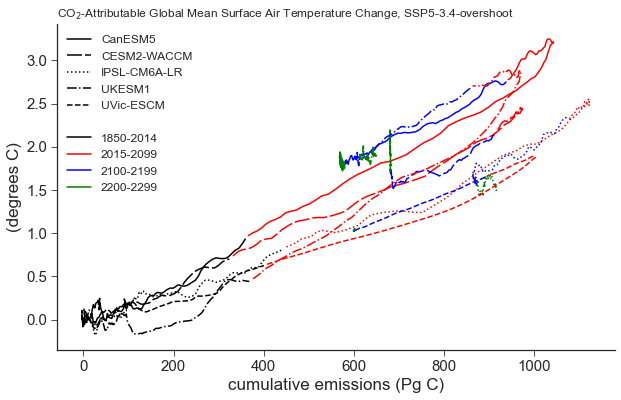

In [78]:
### just show the SSP5-3.4os, but color based on the century, again but now for co2-attributable warming
ax = plt.subplot(111)

colors = ['black','red','blue','green']
linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[1,period_tstart[period_i]:period_tend[period_i], model_i], (tas_trajectories_2exp[model_i,1,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean())*co2attributable_rf[1,period_tstart[period_i]:period_tend[period_i]], color=colors[period_i], linestyle=dashlist[model_i])
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('CO$_2$-Attributable Global Mean Surface Air Temperature Change, SSP5-3.4-overshoot',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False)

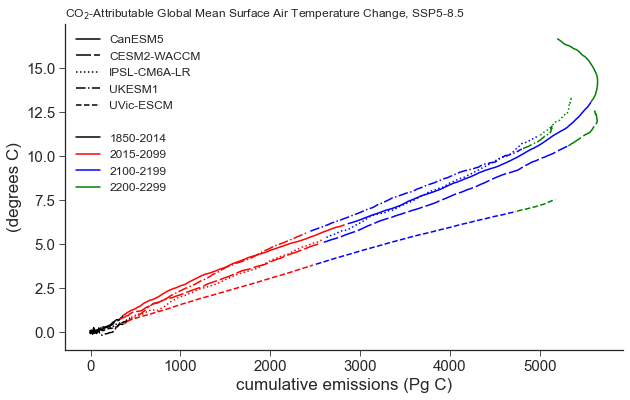

In [79]:
### just show the SSP5-8.5, but color based on the century, again but now for co2-attributable warming
ax = plt.subplot(111)

colors = ['black','red','blue','green']
linelist = []
linelist2 = []
for model_i in range(nmodels):
    for period_i in range(len(period_list)):
        a1, = ax.plot(cum_emissions_pgc[0,period_tstart[period_i]:period_tend[period_i], model_i], (tas_trajectories_2exp[model_i,0,period_tstart[period_i]:period_tend[period_i]] - tas_trajectories_2exp[model_i,0,0:years_to_average_gmst].mean())*co2attributable_rf[0,period_tstart[period_i]:period_tend[period_i]], color=colors[period_i], linestyle=dashlist[model_i])
        if period_i == 0:
            linelist.append(a1)
        if model_i == 0:
            if period_i == 0:
                emptyline, = ax.plot([0.,0.], [0., 0.], linewidth=0.)
                linelist2.append(emptyline)
            linelist2.append(a1)      

#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(degrees C)')
plt.xlabel('cumulative emissions (Pg C)')
plt.title('CO$_2$-Attributable Global Mean Surface Air Temperature Change, SSP5-8.5',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(linelist+linelist2, list(models_list)+['']+period_list, frameon=False)

### below is code to search the ESG and see what variables exist for the 21st and 22nd centuries

In [80]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        ##cdk print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [ ]:
century_strings = ['-22', '-23']

In [ ]:
ssp585_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp585')
for url in ssp585_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp534os_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp534-over')
for url in ssp534os_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp534os_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp534-over')
for url in ssp534os_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp585_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp585')
for url in ssp585_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp585_tas_files = esgf_search(variable_id='tas', experiment_id='ssp585')
for url in ssp585_tas_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp534os_tas_files = esgf_search(variable_id='tas', experiment_id='ssp534-over')
for url in ssp534os_tas_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp534os_cveg_files = esgf_search(variable_id='cSoil', experiment_id='ssp534-over')
for url in ssp534os_cveg_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp126_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp126')
for url in ssp126_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
ssp126_fgco2_files = esgf_search(variable_id='areacella', experiment_id='ssp126')
for url in ssp126_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

In [ ]:
## now load the atmospheric mole fraction of co2 to calculate the cumulative emissions
filename_atmco2_hist = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc'
filename_atmco2_ssp585 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp585-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp534os = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-REMIND-MAGPIE-ssp534-over-1-2-1_gr1-GMNHSH_2015-2500.nc'
filename_atmco2_ssp126 = 'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc'


tmin_co2mf_hist = 0
tmin_co2mf_ssps = 2015


#startyear_exps = [1850, 2015, 2040]
#endyear_exps = [2014, 2299, 2299]

co2_mf_ts_v2 = xr.DataArray(np.ma.masked_all((3,nyears_total)), dims=['scenarios','time'])

co2_molefrac_hist = xr.open_dataset(filename_atmco2_hist, decode_times=False)
hist_co2_ts = co2_molefrac_hist['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[0]-tmin_co2mf_hist,endyear_exps[0]-tmin_co2mf_hist+1))
co2_mf_ts_v2[:,0:endyear_exps[0]-startyear_exps[0]+1] = hist_co2_ts

co2_molefrac_ssp585 = xr.open_dataset(filename_atmco2_ssp585, decode_times=False)
ssp585_co2_ts = co2_molefrac_ssp585['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts_v2[0,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp585_co2_ts

co2_molefrac_ssp534os = xr.open_dataset(filename_atmco2_ssp534os, decode_times=False)
ssp534os_co2_ts = co2_molefrac_ssp534os['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts_v2[1,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp534os_co2_ts

co2_molefrac_ssp126 = xr.open_dataset(filename_atmco2_ssp126, decode_times=False)
ssp126_co2_ts = co2_molefrac_ssp126['mole_fraction_of_carbon_dioxide_in_air'].isel(sector=1, time=slice(startyear_exps[1]-tmin_co2mf_ssps,endyear_exps[1]-tmin_co2mf_ssps+1))
co2_mf_ts_v2[2,startyear_exps[1]-startyear_exps[0]:endyear_exps[1]-startyear_exps[0]+1] = ssp126_co2_ts


#co2_mf_ts.plot()

ax = plt.subplot(111)

ax.plot(years, co2_mf_ts_v2[0,:], color=ssp585_color)
ax.plot(years, co2_mf_ts_v2[1,:], color=ssp534os_color)
ax.plot(years, co2_mf_ts_v2[2,:], color='blue')

    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('ppm CO$_2$')
plt.title('Atmospheric Mole Fraction CO$_2$',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot', 'SSP1-2.6'], frameon=False)

In [ ]:
zonal_mean_anual_nbp_list_concatenated[2][1]